In [1]:
import os
import time
import rasterio
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy import stats, interpolate
from pandas import date_range, to_datetime
import dask
import dask.dataframe as dd
import matplotlib.dates as mdates
import logging
import dask.array as da
from scipy.stats import norm
from joblib import Parallel, delayed
from dask import config as dask_config
from dask.diagnostics import ProgressBar
import warnings
# from helper_functions import * # Helper functions
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula # Using Copulae Module

In [2]:
# Set dataset directory
dataset = '../../../datasets/'
output_dir = '../../../datasets/results'

In [3]:
variables = xr.open_dataset(os.path.join(dataset, 'processed_final_data/daily_dataset'), chunks={'time': 500, 'y': 175, 'x': 148})

In [4]:
tws = xr.open_dataset(os.path.join(dataset, 'processed_final_data/full_gha_daily.nc'),  chunks={'time': 500, 'y': 175, 'x': 148})
# %store tws

In [5]:
# Add the TWS data to the variables
variables['tws_ds'] = tws.twsddk

##### Smoothing function

In [6]:
# Define SMA function
def compute_sma(da, window, dim='time'):
    logging.info(f"Computing SMA for window {window} along dimension {dim}")
    return da.rolling(time=window, center=False).mean()

### Subzone Processing

Some of the zones were already processed and saved to file, so I'll read them here

`The process crash because it was too large and was processed in chunks`

In [7]:
start = time.time()
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes')

# Dictionary to store subregion datasets
subregion_datasets = {}

# Loop through each subregion
for subregion_id in landform_classes[:3]:
    if np.isnan(subregion_id): 
        continue
    # Mask the combined dataset where landform matches the subregion ID
    subregion_mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(subregion_mask, drop=True)
    print(f"Completed subregion {int(subregion_id)} ")
    subregion_datasets[int(subregion_id)] = subregion_ds

print("Subregion 3 dataset:")
print(subregion_datasets[3])
end = time.time()

Extracted Landform classes
Completed subregion 1 
Completed subregion 2 
Completed subregion 3 
Subregion 3 dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, y: 689, x: 575)
Coordinates:
    band           int64 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 50.48 50.58 50.63
  * y              (y) float64 22.77 22.72 22.67 22.62 ... -11.53 -11.58 -11.63
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 0
    lat            (y) float64 dask.array<chunksize=(168,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(148,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(500, 168, 148), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(500, 168, 148), meta=np.ndarray>
    sm             (time, y, x) float64 dask.array<chunksize=(500, 168, 148), meta=np.ndarray>
    tws            (time, y, x) float64 dask.array<chunksize=

In [8]:
# Extract zone
zone = subregion_datasets[3]

In [9]:
subregion_id = 3

##### Calculate Simple moving average

In [10]:
# agregate to montly means
timescales_var_month = {}
for timescale in [30, 90, 180, 360]:
    print(f"Applying SMA with span {timescale}...")
    variables = ['precipitation', 'et', 'sm', 'tws_ds']
    if timescale == 30:
            variables.remove('tws_ds')
    for var in variables:
        print(f'Applying SMA to {var} with span {timescale}...')
        zone[var + f'_{timescale}'] = compute_sma(zone[var], timescale)
    zone[f'pet_{timescale}'] = zone[f'precipitation_{timescale}'] - zone[f'et_{timescale}']

Applying SMA with span 30...
Applying SMA to precipitation with span 30...
Applying SMA to et with span 30...
Applying SMA to sm with span 30...
Applying SMA with span 90...
Applying SMA to precipitation with span 90...
Applying SMA to et with span 90...
Applying SMA to sm with span 90...
Applying SMA to tws_ds with span 90...
Applying SMA with span 180...
Applying SMA to precipitation with span 180...
Applying SMA to et with span 180...
Applying SMA to sm with span 180...
Applying SMA to tws_ds with span 180...
Applying SMA with span 360...
Applying SMA to precipitation with span 360...
Applying SMA to et with span 360...
Applying SMA to sm with span 360...
Applying SMA to tws_ds with span 360...


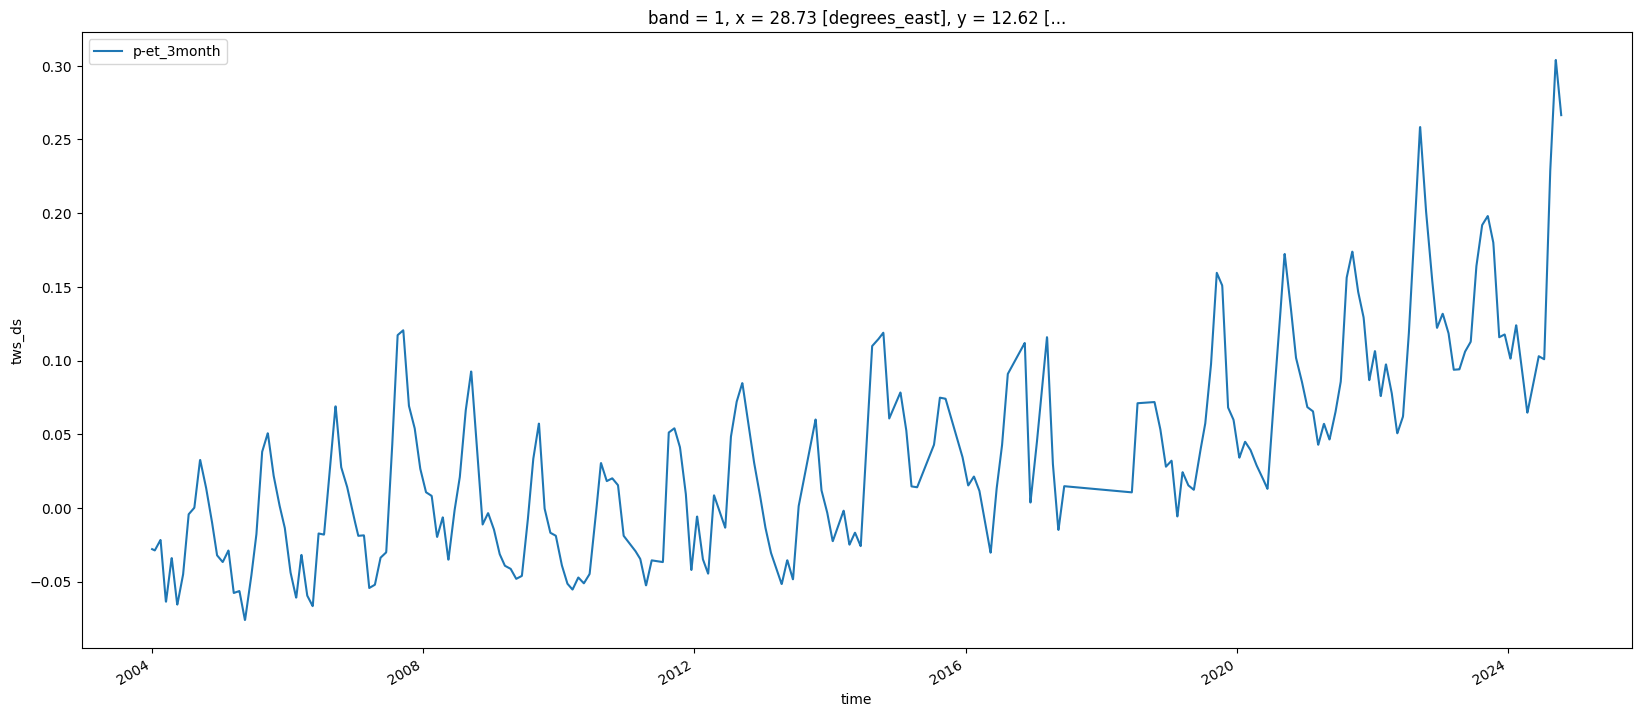

In [11]:
plt.figure(figsize=(20,8))
zone.tws_ds.sel(y=12.61, x= 28.72, method='nearest').plot(label='p-et_3month')
plt.legend()

#### Remove mean over time and standardize

In [12]:
timescales = [30, 90, 180, 360]

stats_dict_ = {}
start = time.time()

variable_groups = {
    30: ['pet_30', 'sm_30', 'tws_ds'],
    90: ['pet_90', 'sm_90', 'tws_ds_90'],
    180: ['pet_180', 'sm_180', 'tws_ds_180'],
    360: ['pet_360', 'sm_360', 'tws_ds_360']
}

# Ddictionary to store standardized datasets
ds_standardized = {}

end = time.time()
print(f"Completed standardization in {end - start:.2f} seconds")

Completed standardization in 0.00 seconds


In [13]:
start = time.time()
# Loop through each timescale
for timescale in timescales:
    print(f"Processing timescale: {timescale} days")
    
    # Select variables for this each timescale
    vars_to_process = variable_groups[timescale]
    
    # Create a dataset for the timescale
    ds_ts = zone[vars_to_process].copy()
    
    # Dicts for means and standard deviations
    means = {}
    stds = {}
    
    # Standardize each variable
    for var in vars_to_process:
            
            mean_var = ds_ts[var].mean(dim='time', skipna=True)
            std_var = ds_ts[var].std(dim='time', skipna=True)
            
            
            ds_ts[var] = (ds_ts[var] - mean_var) / std_var
            
            
            means[var] = mean_var
            stds[var] = std_var
    
    # Create a dataset for statistics (excluding tws_ds, saved separately)
    ds_stats = xr.Dataset({
        **{f'{var}_mean': means[var] for var in vars_to_process},
        **{f'{var}_std': stds[var] for var in vars_to_process}
    })
    
    # Save a NetCDF file
    stats_filename = f'stats_timescale_{timescale}_days.nc'
    # ds_stats.to_netcdf(stats_filename)
    
    # Store the standardized dataset
    ds_standardized[timescale] = ds_ts
    
    # Save the standardized dataset to a NetCDF file
    output_filename = f'standardized_timescale_{timescale}_days.nc'
    # ds_ts.to_netcdf(output_filename)

end = time.time()
print(f"Completed standardization in {end - start:.2f} seconds")

Processing timescale: 30 days
Processing timescale: 90 days
Processing timescale: 180 days
Processing timescale: 360 days
Completed standardization in 0.21 seconds


In [14]:
# Inspect the results for one timescale
print("Standardized Dataset for 30-day timescale:")
print(ds_standardized[30])

Standardized Dataset for 30-day timescale:
<xarray.Dataset>
Dimensions:      (time: 7671, y: 689, x: 575)
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 50.43 50.48 50.58 50.63
  * y            (y) float64 22.77 22.72 22.67 22.62 ... -11.53 -11.58 -11.63
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref  int64 0
    lat          (y) float64 dask.array<chunksize=(168,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(148,), meta=np.ndarray>
Data variables:
    pet_30       (time, y, x) float64 dask.array<chunksize=(529, 168, 148), meta=np.ndarray>
    sm_30        (time, y, x) float64 dask.array<chunksize=(529, 168, 148), meta=np.ndarray>
    tws_ds       (time, y, x) float64 dask.array<chunksize=(500, 168, 148), meta=np.ndarray>


In [15]:
# plt.figure(figsize=(20,8))
# ds_standardized[90]['pet_90'].sel(y=8.61, x= 32.72, method='nearest').plot(label='p-et_3month')
# ds_standardized[90]['sm_90'].sel(y=8.61, x= 32.72, method='nearest').plot(label='sm_3month')
# ds_standardized[90]['tws_ds_90'].sel(y=8.61, x= 32.72, method='nearest').plot(label='tws_3month')
# plt.axhline(0, color='k', linestyle='--')
# # plt.grid(True, which='both', linestyle='--', alpha=0.6)
# plt.show()

In [16]:
# plt.figure(figsize=(20,8))
# ds_standardized[360]['pet_360'].sel(y=8.61, x= 32.72, method='nearest').plot(label='p-et_3month')
# ds_standardized[360]['sm_360'].sel(y=8.61, x= 32.72, method='nearest').plot(label='sm_3month')
# ds_standardized[360]['tws_ds_360'].sel(y=8.61, x= 32.72, method='nearest').plot(label='tws_3month')
# plt.axhline(0, color='k', linestyle='--')
# plt.grid(True, which='both', linestyle='--', alpha=0.6)
# plt.show()

#### 30 days (1-month) time scale

In [17]:
# Load and subsample dataset
ds_30 = ds_standardized[30]
y_subset = ds_30['y'].values[::5]
x_subset = ds_30['x'].values[::5]
ds_30 = ds_30.sel(y=y_subset, x=x_subset)

# Subsample time (every 10th day)
time_subset = ds_30['time'].values[::10]
ds_30 = ds_30.sel(time=time_subset)

In [18]:
print(ds_30)

<xarray.Dataset>
Dimensions:      (time: 768, y: 138, x: 115)
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 22.13 22.38 22.63 ... 49.63 49.88 50.13 50.38
  * y            (y) float64 22.77 22.52 22.27 22.02 ... -10.98 -11.23 -11.48
  * time         (time) datetime64[ns] 2004-01-01 2004-01-11 ... 2024-12-31
    spatial_ref  int64 0
    lat          (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(30,), meta=np.ndarray>
Data variables:
    pet_30       (time, y, x) float64 dask.array<chunksize=(53, 34, 30), meta=np.ndarray>
    sm_30        (time, y, x) float64 dask.array<chunksize=(53, 34, 30), meta=np.ndarray>
    tws_ds       (time, y, x) float64 dask.array<chunksize=(50, 34, 30), meta=np.ndarray>


In [19]:
# Function to compute ECDF transformation per grid point
def ecdf_transform(data):
    valid_data = data[~np.isnan(data)]
    if len(valid_data) == 0:
        return np.full_like(data, np.nan)
    ecdf = ECDF(valid_data)
    transformed = ecdf(data)
    transformed[np.isnan(data)] = np.nan
    return transformed

In [20]:
start_time = time.time()

timescale = 30

# Define the variables to work with
variables = [f'pet_{timescale}', f'sm_{timescale}', 'tws_ds']

# Select the training period (2004 to 2017)
ds_train = ds_30.sel(time=slice('2004-01-01', '2017-12-31')).chunk({'time': -1})

# Apply ECDF transformation to each variable
uniform_ds = xr.Dataset()
for var in variables:
    uniform_data = xr.apply_ufunc(
        ecdf_transform,
        ds_train[var],
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    uniform_ds[var] = uniform_data

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Total runtime: 0.04 seconds.


In [21]:
# Stack each variable time, y, x
stacked_pet = uniform_ds['pet_30'].stack(sample=('time', 'y', 'x'))
stacked_sm = uniform_ds['sm_30'].stack(sample=('time', 'y', 'x'))
stacked_tws = uniform_ds['tws_ds'].stack(sample=('time', 'y', 'x'))

dask_array = da.stack([stacked_pet.data, stacked_sm.data, stacked_tws.data], axis=1)

df = dd.from_dask_array(dask_array, columns=variables)

# Remove any NaN values
df = df.dropna()

In [22]:
# Sample a subset of the data 
n_samples = 5000
n_rows = df.shape[0].compute()
if n_rows > n_samples:
    df_sample = df.sample(frac=n_samples / n_rows)
else:
    df_sample = df

# Compute the sample to get a Pandas DataFrame
df_sample = df_sample.compute()

/home/jovyan/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [23]:
uniform_sample = df_sample.to_numpy()

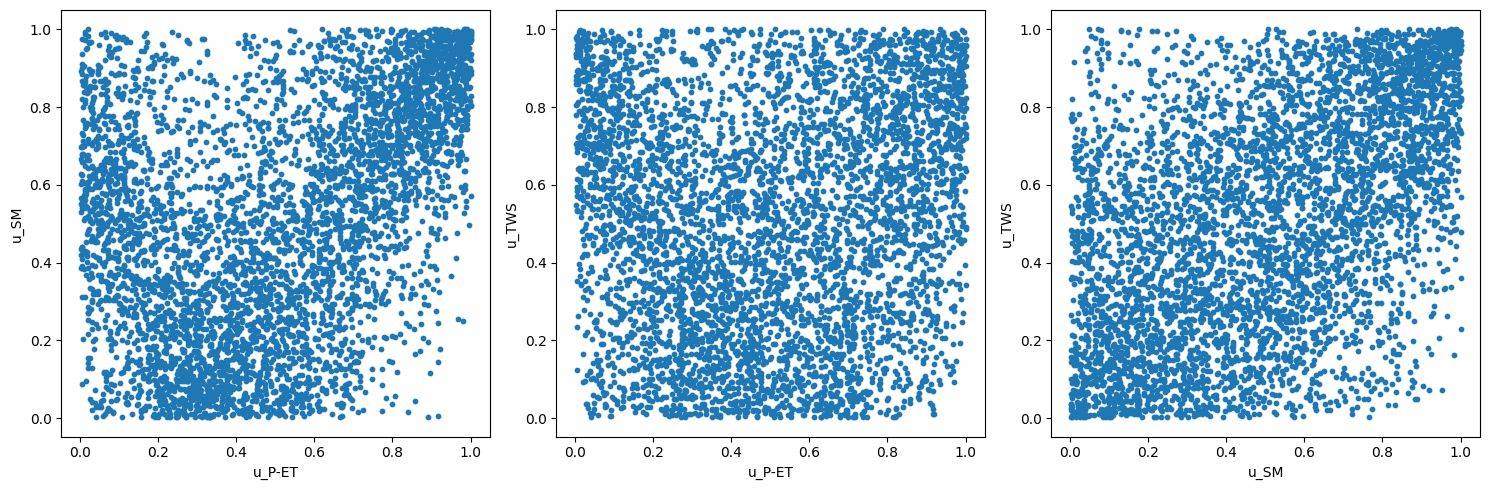

In [24]:
# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], s=10)
axes[0].set_xlabel('u_P-ET')
axes[0].set_ylabel('u_SM')
axes[1].scatter(uniform_sample[:, 0], uniform_sample[:, 2], s=10)
axes[1].set_xlabel('u_P-ET')
axes[1].set_ylabel('u_TWS')
axes[2].scatter(uniform_sample[:, 1], uniform_sample[:, 2], s=10)
axes[2].set_xlabel('u_SM')
axes[2].set_ylabel('u_TWS')
plt.tight_layout()
plt.show()

##### Copula modelling

In [25]:
copulas = {
    'Gaussian': GaussianCopula(dim=3),
    'Clayton': ClaytonCopula(dim=3),
    'Frank': FrankCopula(dim=3),
    'Gumbel': GumbelCopula(dim=3),
    # 'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        start_time = time.time()
        copula.fit(uniform_sample)  #
        log_likelihood = copula.log_lik(uniform_sample)
        
        # Calculate number of paramaters:
        if name == 't-Copula':
            num_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            num_params = np.array(copula.params).size
        elif name == 'Gaussian':
            num_params = copula.params.size
        
        # num_params = copula.dim 
        aic = -2 * log_likelihood + 2 * num_params
        bic = -2 * log_likelihood + num_params * np.log(n_samples)
        
        
        results[name] = {
            'copula': copula, 
            'log_likelihood': log_likelihood, 
            'AIC': aic,
            'BIC': bic,
            'num_params': num_params
        }
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best copula
if results:
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by log_likelihood): {best_copula_name} ('AIC: {results[best_copula_name]['AIC']:.2f}, 'log_likelihood: {results[best_copula_name]['log_likelihood']:.2f})")
else:
    print("No copulas were successfully fitted to the data.")
          
# Save the best copula
with open(f'../../../datasets/results/copulas/fitted_copula_subregion_{subregion_id}_timescale_{timescale}.pkl', 'wb') as f:
    pickle.dump(best_copula, f)

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Fitting Gaussian...
Gaussian Copula fitted for subregion 3, log-likelihood: 1129.78
Fitting Clayton...
Clayton Copula fitted for subregion 3, log-likelihood: 206.75
Fitting Frank...
Frank Copula fitted for subregion 3, log-likelihood: 657.71
Fitting Gumbel...
Gumbel Copula fitted for subregion 3, log-likelihood: 706.10
Best copula (by log_likelihood): Gaussian ('AIC: -2253.56, 'log_likelihood: 1129.78)
Total runtime: 0.21 seconds.


In [26]:
results

{'Gaussian': {'copula': <copulae.elliptical.gaussian.GaussianCopula at 0x7fc186d2ffd0>,
  'log_likelihood': 1129.7803162248638,
  'AIC': -2253.5606324497276,
  'BIC': -2234.009052875479,
  'num_params': 3},
 'Clayton': {'copula': <copulae.archimedean.clayton.ClaytonCopula at 0x7fc186d2fd90>,
  'log_likelihood': 206.75176785908735,
  'AIC': -411.5035357181747,
  'BIC': -404.98634252675845,
  'num_params': 1},
 'Frank': {'copula': <copulae.archimedean.frank.FrankCopula at 0x7fc186d3b040>,
  'log_likelihood': 657.7050682271708,
  'AIC': -1313.4101364543417,
  'BIC': -1306.8929432629254,
  'num_params': 1},
 'Gumbel': {'copula': <copulae.archimedean.gumbel.GumbelCopula at 0x7fc186d3b0d0>,
  'log_likelihood': 706.1010424000477,
  'AIC': -1410.2020848000955,
  'BIC': -1403.6848916086792,
  'num_params': 1}}

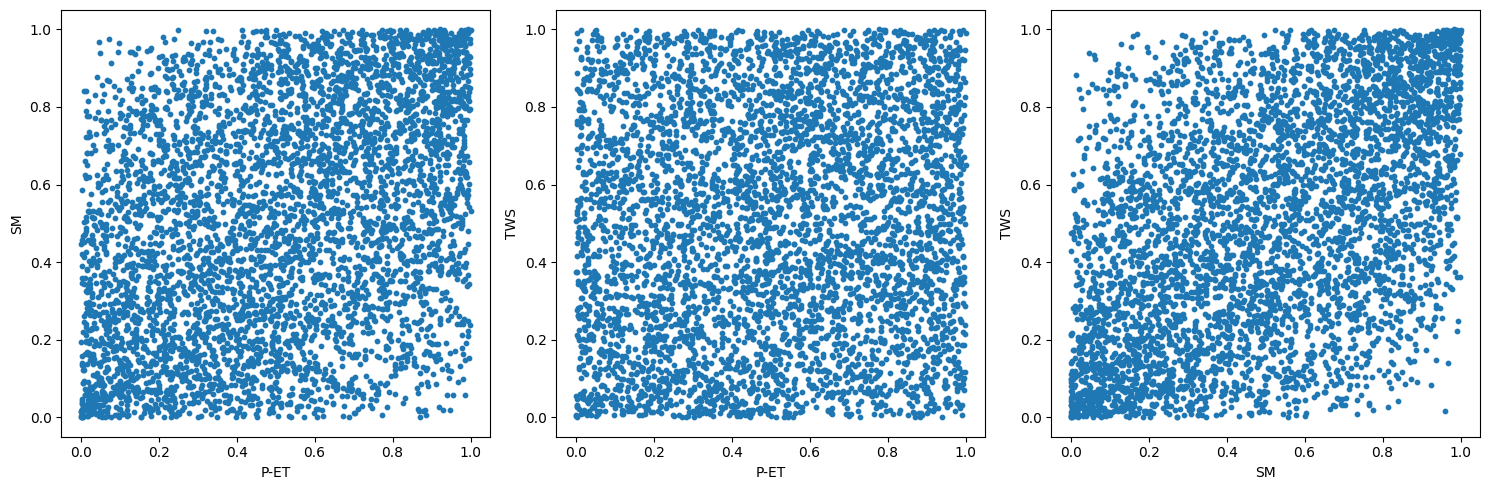

In [27]:
cop_samples = best_copula.random(5000)

# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], s=10)
axes[0].set_xlabel('P-ET')
axes[0].set_ylabel('SM')
axes[1].scatter(cop_samples[:, 0], cop_samples[:, 2], s=10)
axes[1].set_xlabel('P-ET')
axes[1].set_ylabel('TWS')
axes[2].scatter(cop_samples[:, 1], cop_samples[:, 2], s=10)
axes[2].set_xlabel('SM')
axes[2].set_ylabel('TWS')
plt.tight_layout()
plt.show()

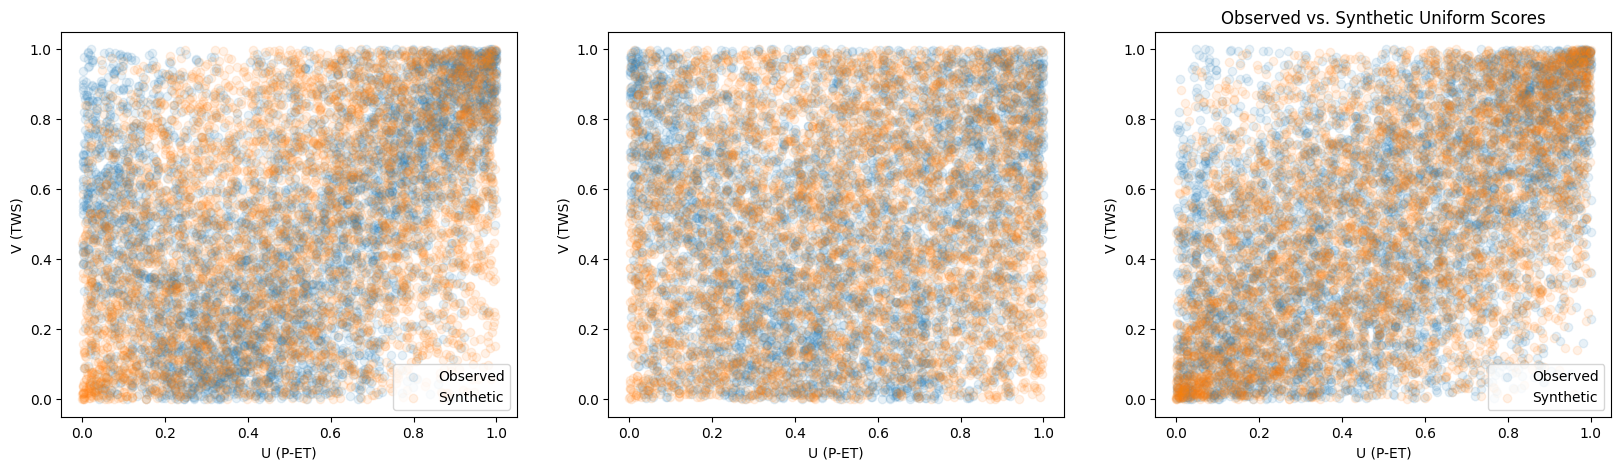

In [28]:
'Generate synthetic samples to compare with observed'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], alpha=0.1, label='Observed')
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], alpha=0.1, label='Synthetic')
axes[0].set_xlabel('U (P-ET)')
axes[0].set_ylabel('V (TWS)')
axes[0].legend()

axes[1].scatter(uniform_sample[:,0], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[1].scatter(cop_samples[:,0], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[1].set_xlabel('U (P-ET)')
axes[1].set_ylabel('V (TWS)')
plt.legend()

axes[2].scatter(uniform_sample[:,1], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[2].scatter(cop_samples[:,1], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[2].set_xlabel('U (P-ET)')
axes[2].set_ylabel('V (TWS)')

plt.legend()
plt.title('Observed vs. Synthetic Uniform Scores')
plt.show()

In [29]:
# Load best copula
# copula_file = f'../../../datasets/results/copulas/fitted_copula_{subregion_id}_{timescale}.pkl'
# with open(copula_file, 'rb') as f:
#     best_copula = pickle.load(f)
# print(best_copula.name)

In [30]:
# Compute joint probabilities in batches
start_time = time.time()
stacked_uniform = uniform_ds.to_array(dim='variable').stack(sample=('time', 'y', 'x')).transpose('sample', 'variable')
n_samples = len(stacked_uniform['sample'])
joint_probs = []
valid_multi_indices = []

In [31]:
# Extract and flatten column names
columns = stacked_uniform['variable'].values.tolist()

# Convert to DataFrame
df = pd.DataFrame(stacked_uniform.compute().values, columns=columns)

# Proceed with valid row check
valid_rows = df.dropna().index
if valid_rows.empty:
    print("No valid rows in region.")
    exit()

df_valid = df.loc[valid_rows]

In [32]:
# Compute joint probabilities
start = time.time()
joint_probs = best_copula.cdf(df_valid.to_numpy())

# Get corresponding sample indices
valid_sample_ids = stacked_uniform.sample.values[valid_rows]
end = time.time()
print(f"Total runtime: {(start_time - end_time):.2f} seconds.")

Total runtime: 2.29 seconds.


In [33]:
# Reconstruct as xarray
multiindex = stacked_uniform['sample'].to_index()
valid_multiindex = multiindex[valid_rows]

# Convert joint probs to DataArray
joint_probs_da = xr.DataArray(
    joint_probs, 
    coords=[valid_multiindex],
    dims='sample').unstack('sample').clip(1e-10, 1 - 1e-10)  # avoid infs

In [34]:
# Convert to drought index
ghdi_plains = xr.apply_ufunc(
    norm.ppf, joint_probs_da).sortby(['y', 'x']) 

ghdi_plains.name = "GHDI Plains"
ghdi_plains.attrs['long_name'] = "Greater Horn of Africa Drought Index"
ghdi_plains.attrs['units'] = "Standard Normal"

In [35]:
# Rescale the index [mean = 0, std = 1]
ghdi_plains['ghdi_30'] = ghdi_plains - ghdi_plains.mean(dim='time')

In [36]:
print(ghdi_plains)

<xarray.DataArray 'GHDI Plains' (time: 509, y: 129, x: 108)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan

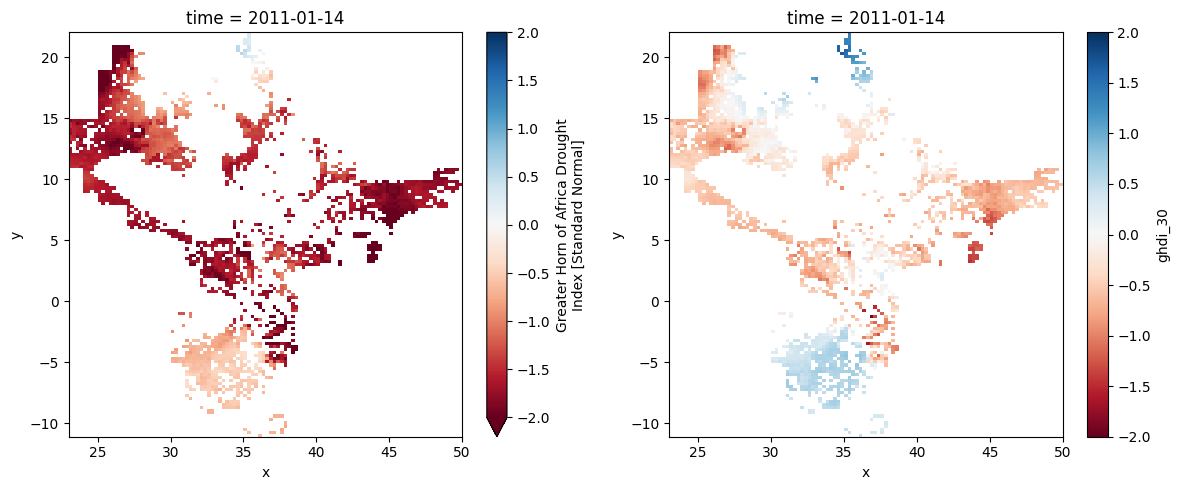

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ghdi_plains.isel(time=254).plot(
    ax=ax1, 
    cmap='RdBu', 
    robust=True,
    vmin=-2, 
    vmax=2
)

ghdi_plains.ghdi_30.isel(time=254).plot(
    ax=ax2,  # specify the axis
    cmap='RdBu',
    robust=True,
    vmin=-2,
    vmax=2
)

plt.tight_layout()
plt.show()

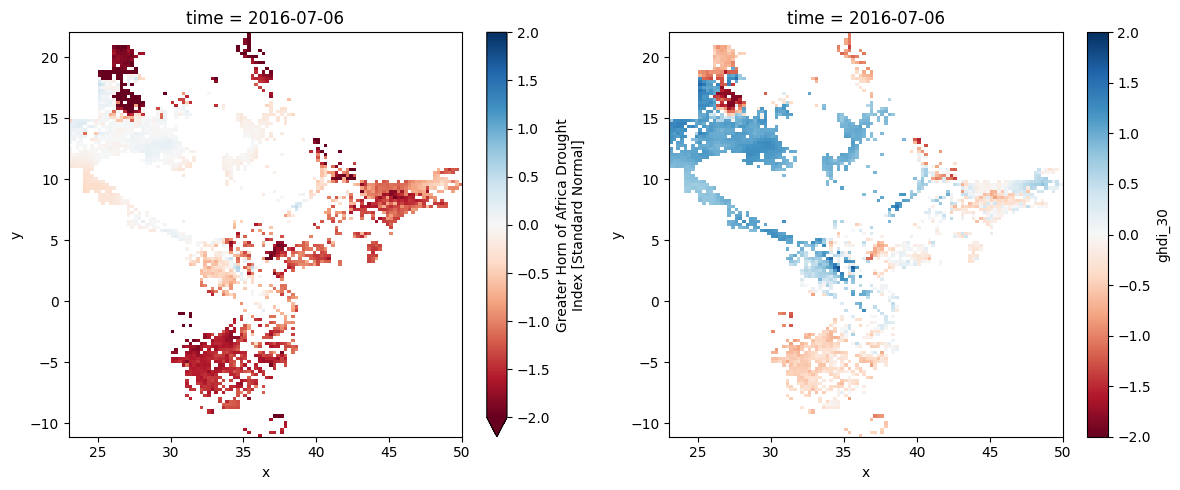

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ghdi_plains.isel(time=454).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
ghdi_plains.ghdi_30.isel(time=454).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

In [39]:
# # Visualization: Time series for a grid point
# plt.figure(figsize=(20, 5))
# ghdi_plains.ghdi_30.sel(y=8.61, x= 32.72, method='nearest').plot()
# plt.axhline(-0.5, color='yellow', linestyle='--')
# plt.axhline(-2, color='red', linestyle='-')
# plt.title(f'Drought Index Time Series (Subregion {subregion_id}, Timescale {timescale} days)')
# plt.xlabel('Time')
# plt.ylabel('GHDI')

In [40]:
# # Visualization: Time series for a grid point
# plt.figure(figsize=(20, 5))
# ghdi_plains.ghdi_30.sel(y=6.61, x= 46.72, method='nearest').plot()
# plt.axhline(0, color='k', linestyle='--')
# plt.axhline(-2, color='k', linestyle='-')
# plt.title(f'Drought Index Time Series (Subregion {subregion_id}, Timescale {timescale} days)')
# plt.xlabel('Time')
# plt.ylabel('Z-scores')

In [41]:
# # Visualization: Time series for a grid point
# grid_point = (ds['y'].values[0], ds['x'].values[0])
# time_series = ghdi_index.sel(y=-1, x=40.7, method='nearest')
# plt.figure(figsize=(20, 5))
# time_series.plot()
# plt.axhline(0, color='k', linestyle='--')
# plt.axhline(-2, color='k', linestyle='-')
# # (spi_90.spi_gamma_90).sel(lat=-7, lon=38, method='nearest').plot()
# plt.title(f'Drought Index Time Series (Subregion {subregion_id}, Timescale {timescale} days, Grid Point {grid_point})')
# plt.xlabel('Time')
# plt.ylabel('GHDI')

##### Regional Variability (Mean)

In [42]:
# f = ghdi_plains.mean(dim=['x', 'y'])
g = ghdi_plains.ghdi_30.mean(dim=['x', 'y'])

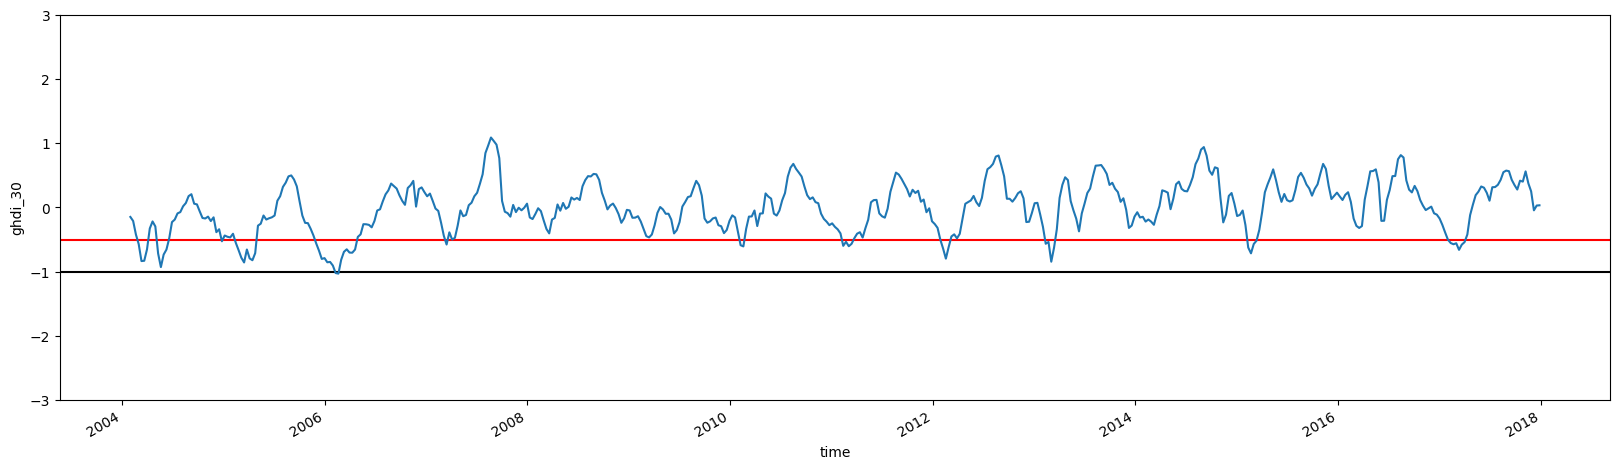

In [43]:
plt.figure(figsize=(20, 5))
plt.ylim(-3, 3)
plt.axhline(-1, linestyle='-', color='k')
plt.axhline(-0.5, linestyle='-', color='red')
g.plot()

##### Validation: Test period (2018–2024)

In [44]:
# Validation: Test period (2018–2024)
ds_test = ds_30.sel(time=slice('2018-01-01', '2024-12-31')).chunk({'time': -1})
uniform_test = xr.Dataset()
for var in variables:
    uniform_data = xr.apply_ufunc(
        ecdf_transform,
        ds_test[var],
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    uniform_test[var] = uniform_data
# uniform_test.to_netcdf(uniform_test_file)

In [45]:
stacked_uniform_test = uniform_test.to_array(dim='variable').stack(
    sample=('time', 'y', 'x')).transpose('sample', 'variable')

start_time = time.time()
columns = stacked_uniform_test['variable'].values.tolist()
df = pd.DataFrame(stacked_uniform_test.compute().values, columns=columns)

valid_rows = df.dropna().index
if valid_rows.empty:
    raise ValueError("No valid rows in test region!")

df_valid = df.loc[valid_rows]

# This can be read from the saved copula file
joint_probs = best_copula.cdf(df_valid.to_numpy())

In [46]:
# Map back to original structure
valid_sample_ids = stacked_uniform_test.sample.values[valid_rows]
multiindex = stacked_uniform_test['sample'].to_index()
valid_multiindex = multiindex[valid_rows]

# Convert joint probs to DataArray
joint_probs_da = xr.DataArray(
    joint_probs, 
    coords=[valid_multiindex], 
    dims='sample').unstack('sample').clip(1e-10, 1 - 1e-10)  # avoid infs


In [47]:
# Convert to drought index
ghdi_plains_test = xr.apply_ufunc(
    norm.ppf, joint_probs_da).sortby(['y', 'x'])

ghdi_plains_test.name = "GHDI Plains"
ghdi_plains_test.attrs['long_name'] = "Greater Horn of Africa Drought Index"
ghdi_plains_test.attrs['units'] = "Standard Normal"

In [48]:
ghdi_plains_test['ghdi_30'] = ghdi_plains_test - ghdi_plains_test.mean(dim='time')

In [49]:
print(ghdi_plains_test)

<xarray.DataArray 'GHDI Plains' (time: 248, y: 129, x: 108)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan

##### Visualisation

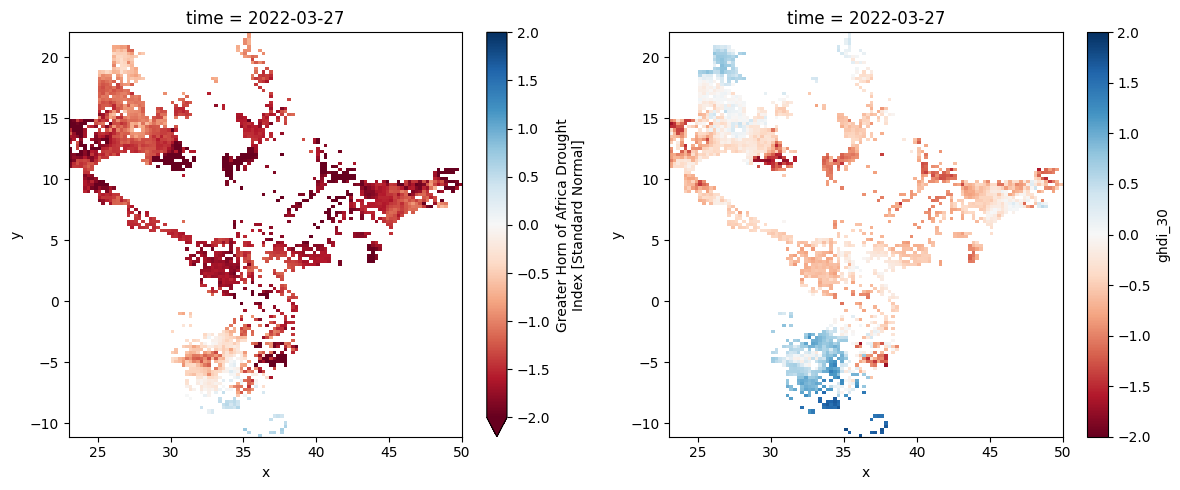

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot (left)
ghdi_plains_test.isel(time=154).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
ghdi_plains_test.ghdi_30.isel(time=154).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

In [51]:
# # Visualization: Time series for a grid point
# plt.figure(figsize=(20, 6))
# grid_point = [6.61, 46.72]
# ghdi_plains_test.sel(y=grid_point[0], x=grid_point[1], method='nearest').plot()
# plt.axhline(-1, linestyle='-', color='k')
# plt.axhline(-0.5, linestyle='-', color='red')
# plt.title(f'Drought Index Time Series (Subregion {subregion_id}, Timescale {timescale} days, at {grid_point})')
# plt.xlabel('Time')
# plt.ylabel('GHDI')

In [52]:
# Combine training and test period
ghdi_combined = xr.merge([ghdi_plains, ghdi_plains_test])
ghdi_combined.to_netcdf(f"ghdi_{subregion_id}_{timescale}.nc")

In [53]:
print(ghdi_combined)

<xarray.Dataset>
Dimensions:      (time: 757, y: 129, x: 108)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-31 2004-02-10 ... 2024-10-12
  * y            (y) float64 -10.98 -10.73 -10.48 -10.23 ... 20.77 21.27 21.77
  * x            (x) float64 23.13 23.38 23.63 23.88 ... 49.13 49.38 49.63 49.88
    ghdi_30      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Data variables:
    GHDI Plains  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Greater Horn of Africa Drought Index
    units:      Standard Normal


In [54]:
# # Visualization: Time series for a grid point
# plt.figure(figsize=(20, 6))
# ghdi_combined.ghdi_30.sel(y=6.61, x=46.72, method='nearest').plot()
# plt.axhline(-0.5, color='yellow', linestyle='--')
# plt.axhline(-2, color='red', linestyle='-')
# plt.title(f'Drought Index Time Series (Subregion {subregion_id}, Timescale {timescale} days)')
# plt.xlabel('Time')
# plt.ylabel('GHDI')
# plt.ylim(-4, 4)
# plt.show()

#### 90 Day time scale

In [55]:
# Load and subsample dataset
ds_90 = ds_standardized[90]
y_subset = ds_90['y'].values[::5]
x_subset = ds_90['x'].values[::5]
ds_90 = ds_90.sel(y=y_subset, x=x_subset)

# Subsample time (every 10th day)
time_subset = ds_90['time'].values[::10]
ds_90 = ds_90.sel(time=time_subset)

In [56]:
print(ds_90)

<xarray.Dataset>
Dimensions:      (time: 768, y: 138, x: 115)
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 22.13 22.38 22.63 ... 49.63 49.88 50.13 50.38
  * y            (y) float64 22.77 22.52 22.27 22.02 ... -10.98 -11.23 -11.48
  * time         (time) datetime64[ns] 2004-01-01 2004-01-11 ... 2024-12-31
    spatial_ref  int64 0
    lat          (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(30,), meta=np.ndarray>
Data variables:
    pet_90       (time, y, x) float64 dask.array<chunksize=(59, 34, 30), meta=np.ndarray>
    sm_90        (time, y, x) float64 dask.array<chunksize=(59, 34, 30), meta=np.ndarray>
    tws_ds_90    (time, y, x) float64 dask.array<chunksize=(59, 34, 30), meta=np.ndarray>


In [57]:
start_time = time.time()

timescale = 90

# Define the variables to work with
variables = [f'pet_{timescale}', f'sm_{timescale}', f'tws_ds_{timescale}']

# Select the training period (2004 to 2017)
ds_full = ds_90.chunk({'time':-1})
# Apply ECDF transformation to each variable
uniform_ds = xr.Dataset()
for var in variables:
    uniform_data = xr.apply_ufunc(
        ecdf_transform,
        ds_full[var],
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    uniform_ds[var] = uniform_data

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Total runtime: 0.03 seconds.


In [58]:
# Stack each variable time, y, x
stacked_pet = uniform_ds['pet_90'].stack(sample=('time', 'y', 'x'))
stacked_sm = uniform_ds['sm_90'].stack(sample=('time', 'y', 'x'))
stacked_tws = uniform_ds['tws_ds_90'].stack(sample=('time', 'y', 'x'))

dask_array = da.stack([stacked_pet.data, stacked_sm.data, stacked_tws.data], axis=1)

df = dd.from_dask_array(dask_array, columns=variables)

# Remove any NaN values
df = df.dropna()

In [59]:
# Sample a subset of the data 
n_samples = 5000
n_rows = df.shape[0].compute()
if n_rows > n_samples:
    df_sample = df.sample(frac=n_samples / n_rows)
else:
    df_sample = df

# Compute the sample to get a Pandas DataFrame
df_sample = df_sample.compute()

In [60]:
uniform_sample = df_sample.to_numpy()

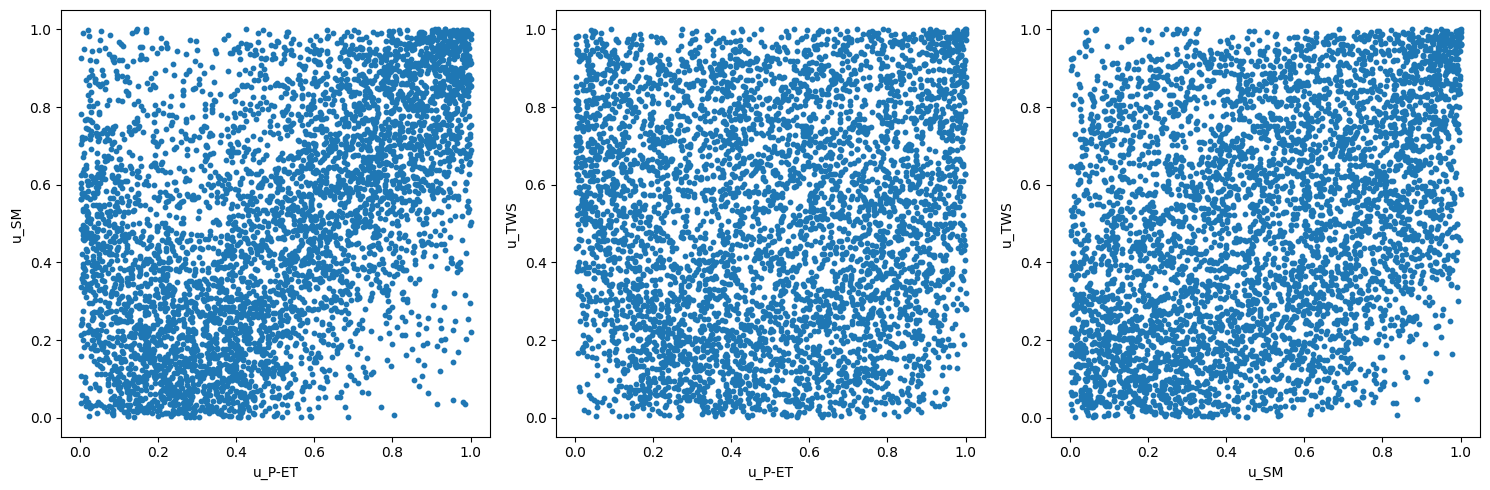

In [61]:
# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], s=10)
axes[0].set_xlabel('u_P-ET')
axes[0].set_ylabel('u_SM')
axes[1].scatter(uniform_sample[:, 0], uniform_sample[:, 2], s=10)
axes[1].set_xlabel('u_P-ET')
axes[1].set_ylabel('u_TWS')
axes[2].scatter(uniform_sample[:, 1], uniform_sample[:, 2], s=10)
axes[2].set_xlabel('u_SM')
axes[2].set_ylabel('u_TWS')
plt.tight_layout()
plt.show()

In [62]:
copulas = {
    'Gaussian': GaussianCopula(dim=3),
    'Clayton': ClaytonCopula(dim=3),
    'Frank': FrankCopula(dim=3),
    'Gumbel': GumbelCopula(dim=3),
    # 'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        start_time = time.time()
        copula.fit(uniform_sample)  #
        log_likelihood = copula.log_lik(uniform_sample)
        
        # Calculate number of paramaters:
        if name == 't-Copula':
            num_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            num_params = np.array(copula.params).size
        elif name == 'Gaussian':
            num_params = copula.params.size
        
        # num_params = copula.dim 
        aic = -2 * log_likelihood + 2 * num_params
        bic = -2 * log_likelihood + num_params * np.log(n_samples)
        
        
        results[name] = {
            'copula': copula, 
            'log_likelihood': log_likelihood, 
            'AIC': aic,
            'BIC': bic,
            'num_params': num_params
        }
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best copula
if results:
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by log_likelihood): {best_copula_name} ('AIC: {results[best_copula_name]['AIC']:.2f}, 'log_likelihood: {results[best_copula_name]['log_likelihood']:.2f})")
else:
    print("No copulas were successfully fitted to the data.")
          
# Save the best copula
with open(f'../../../datasets/results/copulas/fitted_copula_subregion_{subregion_id}_timescale_{timescale}.pkl', 'wb') as f:
    pickle.dump(best_copula, f)

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Fitting Gaussian...
Gaussian Copula fitted for subregion 3, log-likelihood: 938.60
Fitting Clayton...
Clayton Copula fitted for subregion 3, log-likelihood: 214.67
Fitting Frank...
Frank Copula fitted for subregion 3, log-likelihood: 526.94
Fitting Gumbel...
Gumbel Copula fitted for subregion 3, log-likelihood: 529.33
Best copula (by log_likelihood): Gaussian ('AIC: -1871.21, 'log_likelihood: 938.60)
Total runtime: 0.25 seconds.


In [63]:
results

{'Gaussian': {'copula': <copulae.elliptical.gaussian.GaussianCopula at 0x7fc18571b640>,
  'log_likelihood': 938.6032967105407,
  'AIC': -1871.2065934210814,
  'BIC': -1851.6550138468326,
  'num_params': 3},
 'Clayton': {'copula': <copulae.archimedean.clayton.ClaytonCopula at 0x7fc18571b670>,
  'log_likelihood': 214.67294900345053,
  'AIC': -427.34589800690105,
  'BIC': -420.8287048154848,
  'num_params': 1},
 'Frank': {'copula': <copulae.archimedean.frank.FrankCopula at 0x7fc18571b6a0>,
  'log_likelihood': 526.9446974725598,
  'AIC': -1051.8893949451196,
  'BIC': -1045.3722017537034,
  'num_params': 1},
 'Gumbel': {'copula': <copulae.archimedean.gumbel.GumbelCopula at 0x7fc18571b700>,
  'log_likelihood': 529.3342920393501,
  'AIC': -1056.6685840787002,
  'BIC': -1050.151390887284,
  'num_params': 1}}

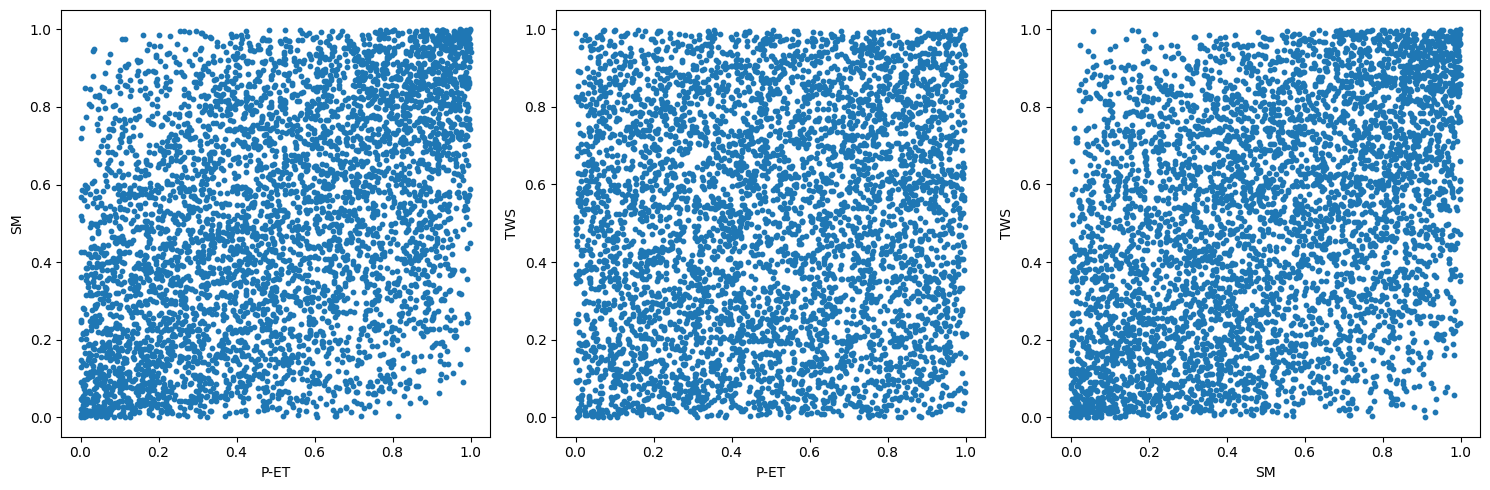

In [64]:
cop_samples = best_copula.random(5000)

# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], s=10)
axes[0].set_xlabel('P-ET')
axes[0].set_ylabel('SM')
axes[1].scatter(cop_samples[:, 0], cop_samples[:, 2], s=10)
axes[1].set_xlabel('P-ET')
axes[1].set_ylabel('TWS')
axes[2].scatter(cop_samples[:, 1], cop_samples[:, 2], s=10)
axes[2].set_xlabel('SM')
axes[2].set_ylabel('TWS')
plt.tight_layout()
plt.show()

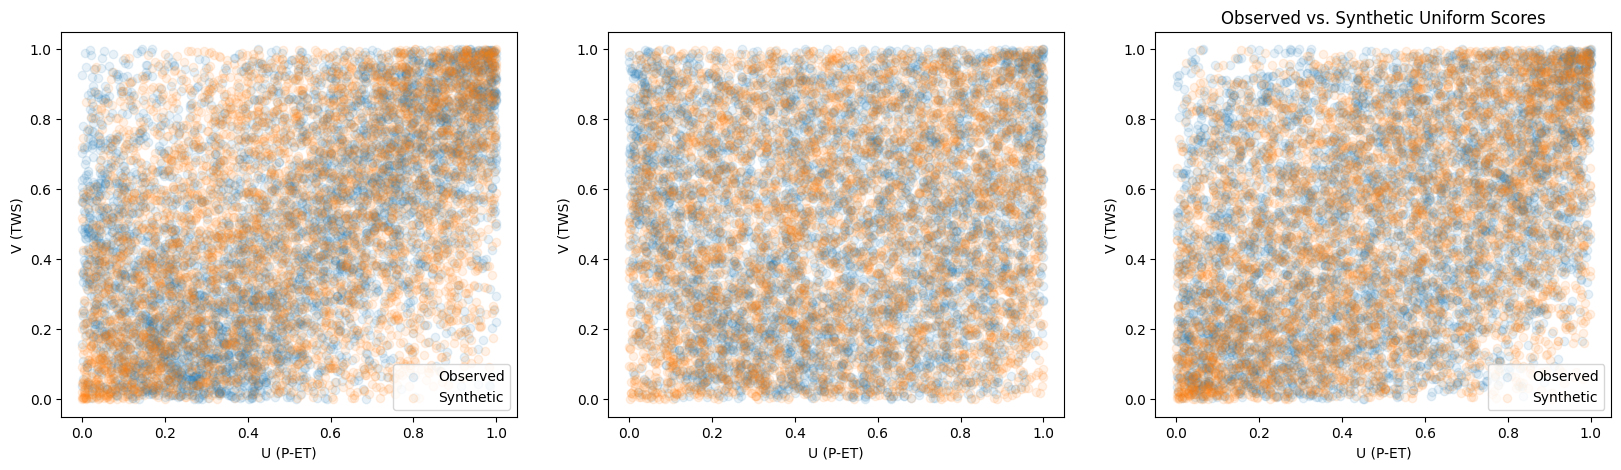

In [65]:
'Generate synthetic samples to compare with observed'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], alpha=0.1, label='Observed')
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], alpha=0.1, label='Synthetic')
axes[0].set_xlabel('U (P-ET)')
axes[0].set_ylabel('V (TWS)')
axes[0].legend()

axes[1].scatter(uniform_sample[:,0], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[1].scatter(cop_samples[:,0], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[1].set_xlabel('U (P-ET)')
axes[1].set_ylabel('V (TWS)')
plt.legend()

axes[2].scatter(uniform_sample[:,1], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[2].scatter(cop_samples[:,1], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[2].set_xlabel('U (P-ET)')
axes[2].set_ylabel('V (TWS)')

plt.legend()
plt.title('Observed vs. Synthetic Uniform Scores')
plt.show()

In [66]:
# Load best copula
# copula_file = f'../../../datasets/results/copulas/fitted_copula_subregion_1_timescale_90.pkl'
# with open(copula_file, 'rb') as f:
#     best_copula = pickle.load(f)
# print(best_copula.name)

In [67]:
# Compute joint probabilities in batches
start_time = time.time()
stacked_uniform = uniform_ds.to_array(dim='variable').stack(sample=('time', 'y', 'x')).transpose('sample', 'variable')
n_samples = len(stacked_uniform['sample'])
joint_probs = []
valid_multi_indices = []

In [68]:
# Extract and flatten column names safely
columns = stacked_uniform['variable'].values.tolist()

# Convert to DataFrame
df = pd.DataFrame(stacked_uniform.compute().values, columns=columns)

# Proceed with valid row check
valid_rows = df.dropna().index
if valid_rows.empty:
    print("No valid rows in region.")
    exit()

df_valid = df.loc[valid_rows]

In [69]:
# Compute joint probabilities
start = time.time()
joint_probs = best_copula.cdf(df_valid.to_numpy())

# Get corresponding sample indices
valid_sample_ids = stacked_uniform.sample.values[valid_rows]
end = time.time()
print(f"Total runtime: {(start_time - end_time):.2f} seconds.")

Total runtime: 2.43 seconds.


In [70]:
# Reconstruct as xarray
multiindex = stacked_uniform['sample'].to_index()
valid_multiindex = multiindex[valid_rows]

joint_probs_da = xr.DataArray(
    joint_probs, 
    coords=[valid_multiindex], 
    dims='sample').unstack('sample').clip(1e-10, 1 - 1e-10)  # avoid infs


In [71]:
# Convert to drought index
ghdi_plains_90 = xr.apply_ufunc(
    norm.ppf, joint_probs_da).sortby(['y', 'x'])

ghdi_plains_90.name = "GHDIPlains_90"
ghdi_plains_90.attrs['long_name'] = "Greater Horn of Africa Drought Index"
ghdi_plains_90.attrs['units'] = "Standard Normal"

In [72]:
ghdi_plains_90['ghdi_90'] = ghdi_plains_90 - ghdi_plains_90.mean(dim='time')

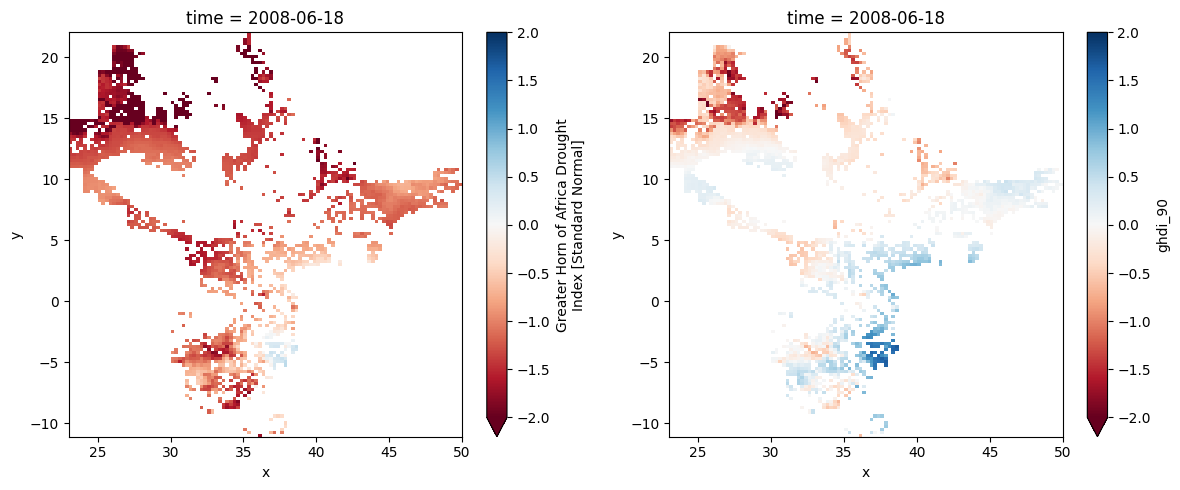

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Normalised index
ghdi_plains_90.isel(time=154).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
ghdi_plains_90.ghdi_90.isel(time=154).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

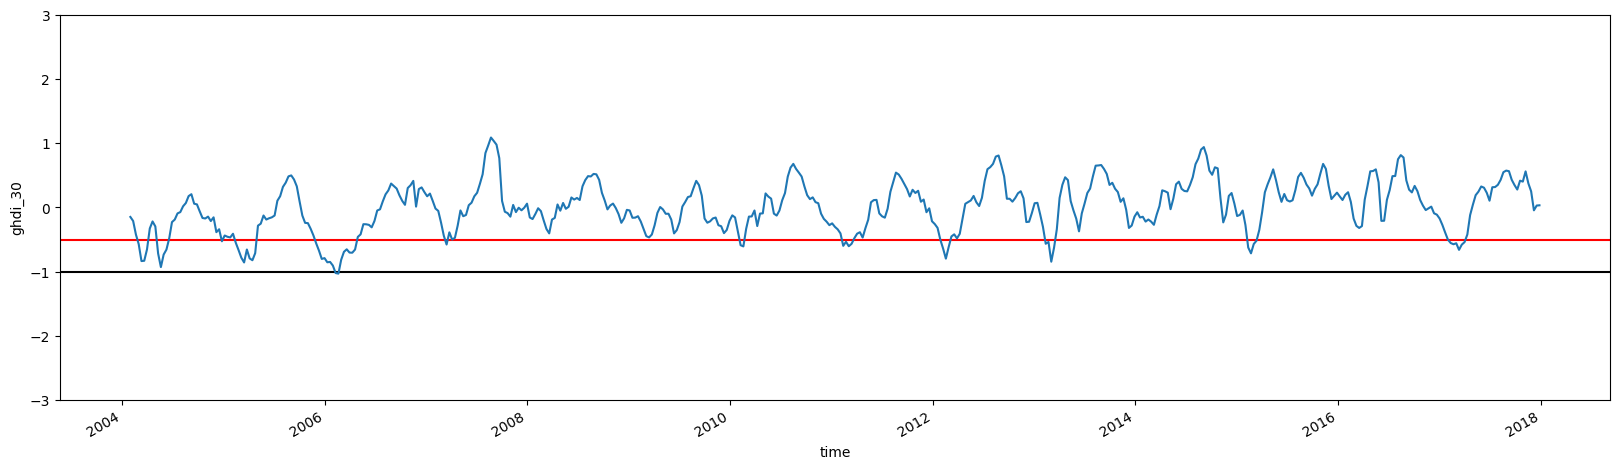

In [74]:
# Regional mean

# f = ghdi_plains.mean(dim=['x', 'y'])
ghdi_plains_90.ghdi_90.mean(dim=['x', 'y'])
plt.figure(figsize=(20, 5))
plt.ylim(-3, 3)
plt.axhline(-1, linestyle='-', color='k')
plt.axhline(-0.5, linestyle='-', color='red')
g.plot()

In [75]:
# plt.figure(figsize=(20, 6))
# ghdi_plains_90.ghdi_90.sel(y=-1, x=40, method='nearest').plot()
# plt.ylim(-4, 4)
# plt.axhline(0)
# plt.axhline(-0.5, color='orange', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [76]:
# plt.figure(figsize=(20, 6))
# ghdi_plains_90.ghdi_90.sel(y=-1, x=40, method='nearest').plot()
# plt.ylim(-4, 4)
# plt.axhline(0)
# plt.axhline(-0.5, color='orange', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [77]:
# Save index to disk
ghdi_plains_90.to_netcdf(f'ghdi_{subregion_id}_{timescale}.nc')

#### 180 Day time scale

In [78]:
# Load and subsample dataset
ds_180 = ds_standardized[180]
y_subset = ds_180['y'].values[::5]
x_subset = ds_180['x'].values[::5]
ds_180 = ds_180.sel(y=y_subset, x=x_subset)

# Subsample time (every 10th day)
time_subset = ds_180['time'].values[::10]
ds_180 = ds_180.sel(time=time_subset)

In [79]:
print(ds_180)

<xarray.Dataset>
Dimensions:      (time: 768, y: 138, x: 115)
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 22.13 22.38 22.63 ... 49.63 49.88 50.13 50.38
  * y            (y) float64 22.77 22.52 22.27 22.02 ... -10.98 -11.23 -11.48
  * time         (time) datetime64[ns] 2004-01-01 2004-01-11 ... 2024-12-31
    spatial_ref  int64 0
    lat          (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(30,), meta=np.ndarray>
Data variables:
    pet_180      (time, y, x) float64 dask.array<chunksize=(68, 34, 30), meta=np.ndarray>
    sm_180       (time, y, x) float64 dask.array<chunksize=(68, 34, 30), meta=np.ndarray>
    tws_ds_180   (time, y, x) float64 dask.array<chunksize=(68, 34, 30), meta=np.ndarray>


In [80]:
start_time = time.time()

timescale = 180

# Define the variables to work with
variables = [f'pet_{timescale}', f'sm_{timescale}', f'tws_ds_{timescale}']

ds_full = ds_180.chunk({'time':-1})
# Apply ECDF transformation to each variable
uniform_ds = xr.Dataset()
for var in variables:
    uniform_data = xr.apply_ufunc(
        ecdf_transform,
        ds_full[var],
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    uniform_ds[var] = uniform_data

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Total runtime: 0.15 seconds.


In [81]:
# Stack each variable time, y, x
stacked_pet = uniform_ds['pet_180'].stack(sample=('time', 'y', 'x'))
stacked_sm = uniform_ds['sm_180'].stack(sample=('time', 'y', 'x'))
stacked_tws = uniform_ds['tws_ds_180'].stack(sample=('time', 'y', 'x'))

dask_array = da.stack([stacked_pet.data, stacked_sm.data, stacked_tws.data], axis=1)

df = dd.from_dask_array(dask_array, columns=variables)

# Remove any NaN values
df = df.dropna()

In [82]:
# Sample a subset of the data 
n_samples = 5000
n_rows = df.shape[0].compute()
if n_rows > n_samples:
    df_sample = df.sample(frac=n_samples / n_rows)
else:
    df_sample = df

# Compute the sample to get a Pandas DataFrame
df_sample = df_sample.compute()

In [83]:
uniform_sample = df_sample.to_numpy()

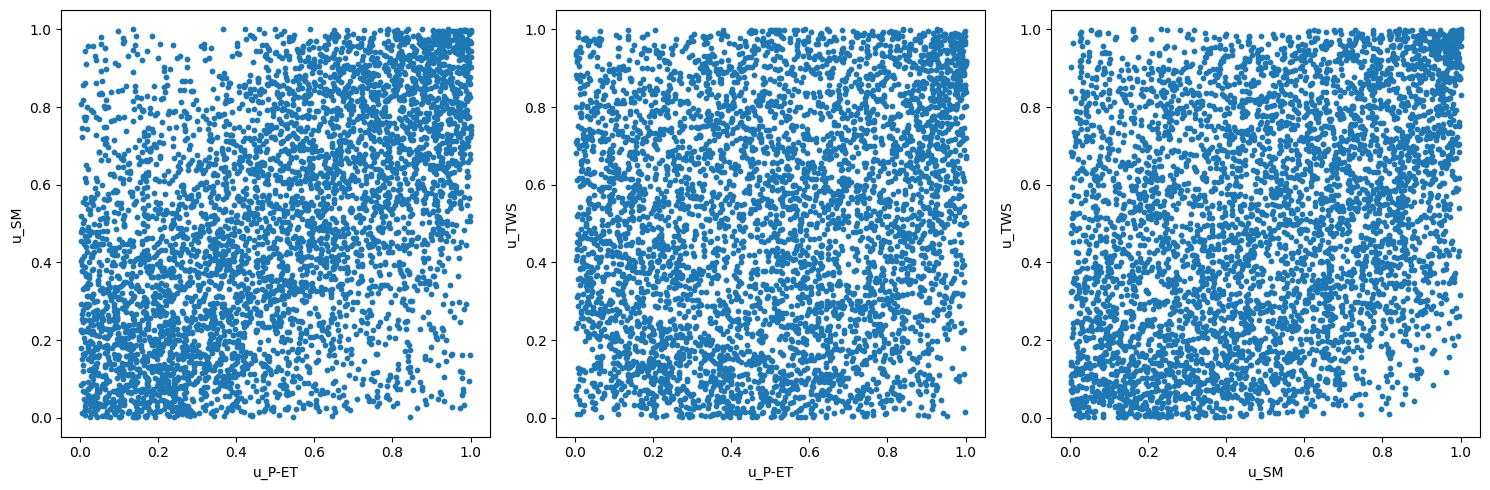

In [84]:
# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], s=10)
axes[0].set_xlabel('u_P-ET')
axes[0].set_ylabel('u_SM')
axes[1].scatter(uniform_sample[:, 0], uniform_sample[:, 2], s=10)
axes[1].set_xlabel('u_P-ET')
axes[1].set_ylabel('u_TWS')
axes[2].scatter(uniform_sample[:, 1], uniform_sample[:, 2], s=10)
axes[2].set_xlabel('u_SM')
axes[2].set_ylabel('u_TWS')
plt.tight_layout()
plt.show()

In [85]:
copulas = {
    'Gaussian': GaussianCopula(dim=3),
    'Clayton': ClaytonCopula(dim=3),
    'Frank': FrankCopula(dim=3),
    'Gumbel': GumbelCopula(dim=3),
    # 'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        start_time = time.time()
        copula.fit(uniform_sample)  #
        log_likelihood = copula.log_lik(uniform_sample)
        
        # Calculate number of paramaters:
        if name == 't-Copula':
            num_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            num_params = np.array(copula.params).size
        elif name == 'Gaussian':
            num_params = copula.params.size
        
        # num_params = copula.dim 
        aic = -2 * log_likelihood + 2 * num_params
        bic = -2 * log_likelihood + num_params * np.log(n_samples)
        
        
        results[name] = {
            'copula': copula, 
            'log_likelihood': log_likelihood, 
            'AIC': aic,
            'BIC': bic,
            'num_params': num_params
        }
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best copula
if results:
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by log_likelihood): {best_copula_name} ('AIC: {results[best_copula_name]['AIC']:.2f}, 'log_likelihood: {results[best_copula_name]['log_likelihood']:.2f})")
else:
    print("No copulas were successfully fitted to the data.")
          
# Save the best copula
with open(f'../../../datasets/results/copulas/fitted_copula_subregion_{subregion_id}_timescale_{timescale}.pkl', 'wb') as f:
    pickle.dump(best_copula, f)

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Fitting Gaussian...
Gaussian Copula fitted for subregion 3, log-likelihood: 943.33
Fitting Clayton...
Clayton Copula fitted for subregion 3, log-likelihood: 385.18
Fitting Frank...
Frank Copula fitted for subregion 3, log-likelihood: 696.86
Fitting Gumbel...
Gumbel Copula fitted for subregion 3, log-likelihood: 650.24
Best copula (by log_likelihood): Gaussian ('AIC: -1880.66, 'log_likelihood: 943.33)
Total runtime: 0.24 seconds.


In [86]:
results

{'Gaussian': {'copula': <copulae.elliptical.gaussian.GaussianCopula at 0x7fbec681fc10>,
  'log_likelihood': 943.328652430147,
  'AIC': -1880.657304860294,
  'BIC': -1861.1057252860453,
  'num_params': 3},
 'Clayton': {'copula': <copulae.archimedean.clayton.ClaytonCopula at 0x7fbec681fc40>,
  'log_likelihood': 385.176394349406,
  'AIC': -768.352788698812,
  'BIC': -761.8355955073957,
  'num_params': 1},
 'Frank': {'copula': <copulae.archimedean.frank.FrankCopula at 0x7fbec681fc70>,
  'log_likelihood': 696.860913388022,
  'AIC': -1391.721826776044,
  'BIC': -1385.2046335846278,
  'num_params': 1},
 'Gumbel': {'copula': <copulae.archimedean.gumbel.GumbelCopula at 0x7fbec681fcd0>,
  'log_likelihood': 650.2433470107558,
  'AIC': -1298.4866940215115,
  'BIC': -1291.9695008300953,
  'num_params': 1}}

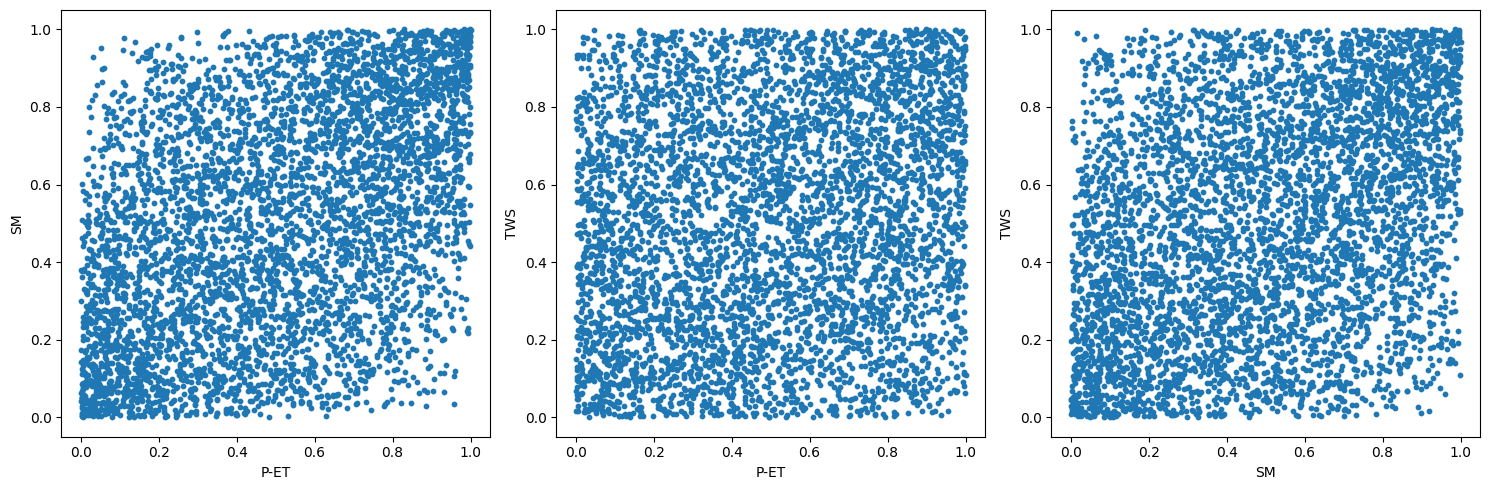

In [87]:
cop_samples = best_copula.random(5000)

# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], s=10)
axes[0].set_xlabel('P-ET')
axes[0].set_ylabel('SM')
axes[1].scatter(cop_samples[:, 0], cop_samples[:, 2], s=10)
axes[1].set_xlabel('P-ET')
axes[1].set_ylabel('TWS')
axes[2].scatter(cop_samples[:, 1], cop_samples[:, 2], s=10)
axes[2].set_xlabel('SM')
axes[2].set_ylabel('TWS')
plt.tight_layout()
plt.show()

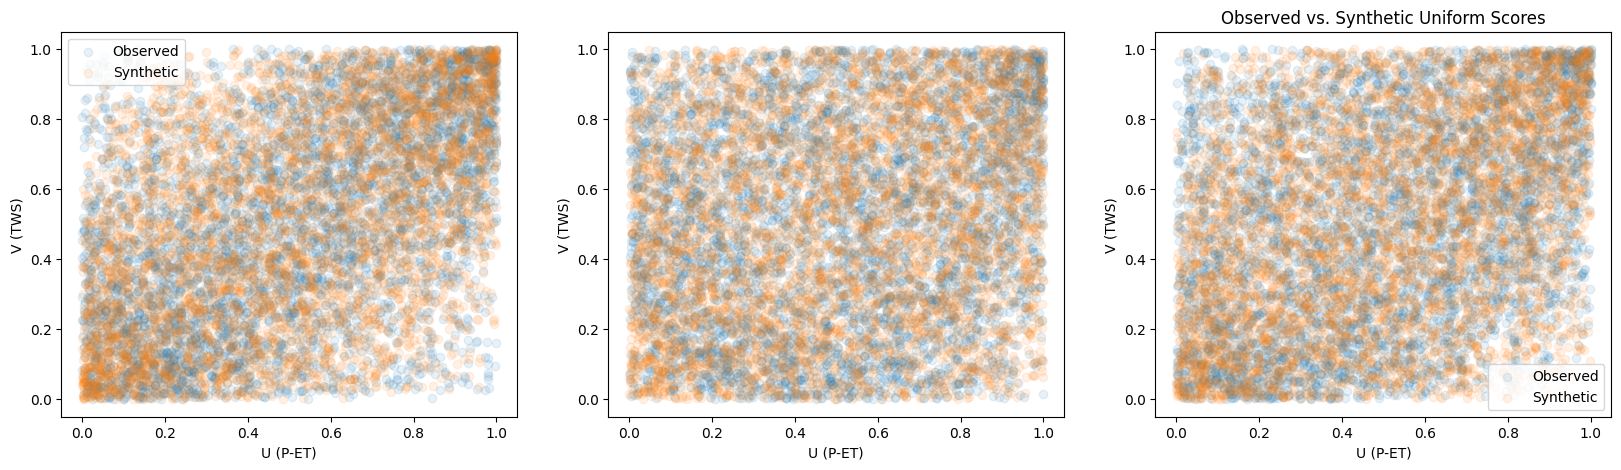

In [88]:
'Generate synthetic samples to compare with observed'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], alpha=0.1, label='Observed')
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], alpha=0.1, label='Synthetic')
axes[0].set_xlabel('U (P-ET)')
axes[0].set_ylabel('V (TWS)')
axes[0].legend()

axes[1].scatter(uniform_sample[:,0], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[1].scatter(cop_samples[:,0], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[1].set_xlabel('U (P-ET)')
axes[1].set_ylabel('V (TWS)')
plt.legend()

axes[2].scatter(uniform_sample[:,1], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[2].scatter(cop_samples[:,1], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[2].set_xlabel('U (P-ET)')
axes[2].set_ylabel('V (TWS)')

plt.legend()
plt.title('Observed vs. Synthetic Uniform Scores')
plt.show()

In [89]:
# # Load best copula
# copula_file = f'../../../datasets/results/copulas/fitted_copula_{subregion_id}_{timescale}.pkl'
# with open(copula_file, 'rb') as f:
#     best_copula = pickle.load(f)
# print(best_copula.name)

In [90]:
# Compute joint probabilities in batches
start_time = time.time()
stacked_uniform = uniform_ds.to_array(dim='variable').stack(sample=('time', 'y', 'x')).transpose('sample', 'variable')
n_samples = len(stacked_uniform['sample'])
joint_probs = []
valid_multi_indices = []

In [91]:
# Extract and flatten column names safely
columns = stacked_uniform['variable'].values.tolist()

# Convert to DataFrame
df = pd.DataFrame(stacked_uniform.compute().values, columns=columns)

# Proceed with valid row check
valid_rows = df.dropna().index
if valid_rows.empty:
    print("No valid rows in region.")
    exit()

df_valid = df.loc[valid_rows]

In [92]:
# Compute joint probabilities
start = time.time()
joint_probs = best_copula.cdf(df_valid.to_numpy())

# Get corresponding sample indices
valid_sample_ids = stacked_uniform.sample.values[valid_rows]
end = time.time()
print(f"Total runtime: {(start_time - end_time):.2f} seconds.")

Total runtime: 2.48 seconds.


In [93]:
# Reconstruct as xarray
multiindex = stacked_uniform['sample'].to_index()
valid_multiindex = multiindex[valid_rows]

joint_probs_da = xr.DataArray(
    joint_probs, 
    coords=[valid_multiindex], 
    dims='sample').unstack('sample').clip(1e-10, 1 - 1e-10)  # avoid infs


In [94]:
# Convert to drought index
ghdi_plains_180 = xr.apply_ufunc(
    norm.ppf, joint_probs_da).sortby(['y', 'x'])

ghdi_plains_180.name = "GHDIPlains_180"
ghdi_plains_180.attrs['long_name'] = "Greater Horn of Africa Drought Index"
ghdi_plains_180.attrs['units'] = "Standard Normal"

In [95]:
ghdi_plains_180['ghdi_180'] = ghdi_plains_180 - ghdi_plains_180.mean(dim='time')

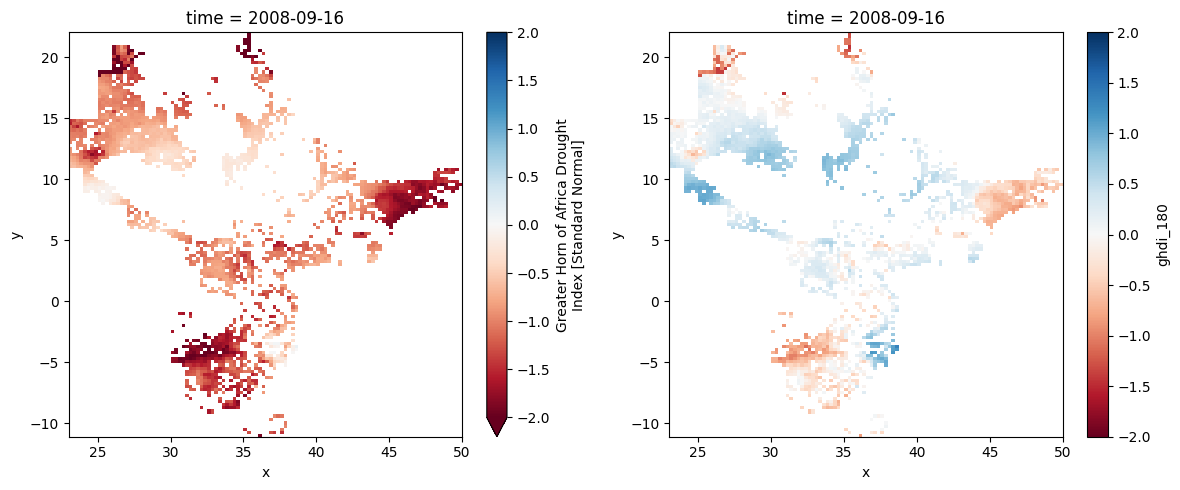

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Normalised index
ghdi_plains_180.isel(time=154).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
ghdi_plains_180.ghdi_180.isel(time=154).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

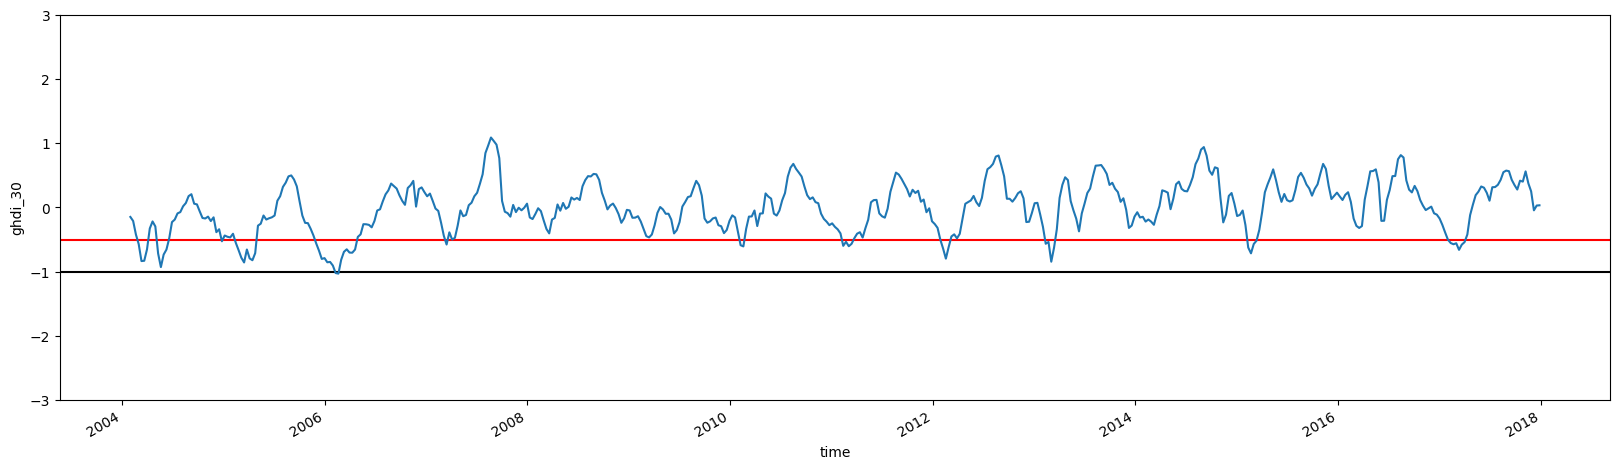

In [97]:
# Regional mean

# f = ghdi_plains.mean(dim=['x', 'y'])
ghdi_plains_180.ghdi_180.mean(dim=['x', 'y'])
plt.figure(figsize=(20, 5))
plt.ylim(-3, 3)
plt.axhline(-1, linestyle='-', color='k')
plt.axhline(-0.5, linestyle='-', color='red')
g.plot()

In [98]:
# plt.figure(figsize=(20, 6))
# ghdi_plains_180.ghdi_180.sel(y=-1, x=40, method='nearest').plot()
# plt.ylim(-4, 4)
# plt.axhline(0)
# plt.axhline(-0.5, color='orange', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [99]:
# plt.figure(figsize=(20, 6))
# ghdi_plains_180.ghdi_180.sel(y=-1, x=40, method='nearest').plot(color='k', label='GHDI-6')
# plt.ylim(-4, 4)
# plt.axhline(0)
# plt.axhline(-0.5, color='red', alpha=.5)
# # plt.axhline(-2, color='red', alpha=0.3)
# plt.legend(loc='upper right')

In [100]:
# Save index to disk
ghdi_plains_180.to_netcdf(f'ghdi_{subregion_id}_{timescale}.nc')

#### 360-Day time scale

In [101]:
# Load and subsample dataset
ds_360 = ds_standardized[360]
y_subset = ds_360['y'].values[::5]
x_subset = ds_360['x'].values[::5]
ds_360 = ds_360.sel(y=y_subset, x=x_subset)

# Subsample time (every 10th day)
time_subset = ds_360['time'].values[::10]
ds_360 = ds_360.sel(time=time_subset)

In [102]:
print(ds_360)

<xarray.Dataset>
Dimensions:      (time: 768, y: 138, x: 115)
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 22.13 22.38 22.63 ... 49.63 49.88 50.13 50.38
  * y            (y) float64 22.77 22.52 22.27 22.02 ... -10.98 -11.23 -11.48
  * time         (time) datetime64[ns] 2004-01-01 2004-01-11 ... 2024-12-31
    spatial_ref  int64 0
    lat          (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
    lon          (x) float64 dask.array<chunksize=(30,), meta=np.ndarray>
Data variables:
    pet_360      (time, y, x) float64 dask.array<chunksize=(86, 34, 30), meta=np.ndarray>
    sm_360       (time, y, x) float64 dask.array<chunksize=(86, 34, 30), meta=np.ndarray>
    tws_ds_360   (time, y, x) float64 dask.array<chunksize=(86, 34, 30), meta=np.ndarray>


In [103]:
start_time = time.time()

timescale = 360

# Define the variables to work with
variables = [f'pet_{timescale}', f'sm_{timescale}', f'tws_ds_{timescale}']

ds_full = ds_360.chunk({'time':-1})

# Apply ECDF transformation to each variable
uniform_ds = xr.Dataset()
for var in variables:
    uniform_data = xr.apply_ufunc(
        ecdf_transform,
        ds_full[var],
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    uniform_ds[var] = uniform_data

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Total runtime: 0.03 seconds.


In [104]:
# Stack each variable time, y, x
stacked_pet = uniform_ds['pet_360'].stack(sample=('time', 'y', 'x'))
stacked_sm = uniform_ds['sm_360'].stack(sample=('time', 'y', 'x'))
stacked_tws = uniform_ds['tws_ds_360'].stack(sample=('time', 'y', 'x'))

dask_array = da.stack([stacked_pet.data, stacked_sm.data, stacked_tws.data], axis=1)

df = dd.from_dask_array(dask_array, columns=variables)

# Remove any NaN values
df = df.dropna()

In [105]:
# Sample a subset of the data 
n_samples = 5000
n_rows = df.shape[0].compute()
if n_rows > n_samples:
    df_sample = df.sample(frac=n_samples / n_rows)
else:
    df_sample = df

# Compute the sample to get a Pandas DataFrame
df_sample = df_sample.compute()

In [106]:
uniform_sample = df_sample.to_numpy()

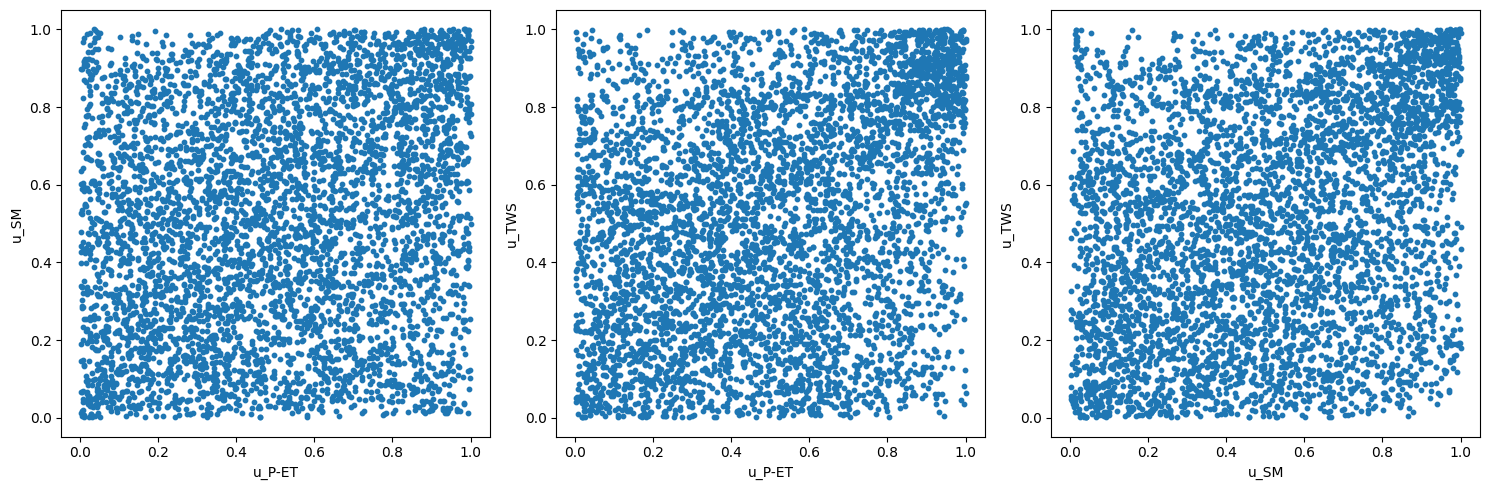

In [107]:
# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], s=10)
axes[0].set_xlabel('u_P-ET')
axes[0].set_ylabel('u_SM')
axes[1].scatter(uniform_sample[:, 0], uniform_sample[:, 2], s=10)
axes[1].set_xlabel('u_P-ET')
axes[1].set_ylabel('u_TWS')
axes[2].scatter(uniform_sample[:, 1], uniform_sample[:, 2], s=10)
axes[2].set_xlabel('u_SM')
axes[2].set_ylabel('u_TWS')
plt.tight_layout()
plt.show()

In [108]:
copulas = {
    'Gaussian': GaussianCopula(dim=3),
    'Clayton': ClaytonCopula(dim=3),
    'Frank': FrankCopula(dim=3),
    'Gumbel': GumbelCopula(dim=3),
    # 'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        start_time = time.time()
        copula.fit(uniform_sample)  #
        log_likelihood = copula.log_lik(uniform_sample)
        
        # Calculate number of paramaters:
        if name == 't-Copula':
            num_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            num_params = np.array(copula.params).size
        elif name == 'Gaussian':
            num_params = copula.params.size
        
        # num_params = copula.dim 
        aic = -2 * log_likelihood + 2 * num_params
        bic = -2 * log_likelihood + num_params * np.log(n_samples)
        
        
        results[name] = {
            'copula': copula, 
            'log_likelihood': log_likelihood, 
            'AIC': aic,
            'BIC': bic,
            'num_params': num_params
        }
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best copula
if results:
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by log_likelihood): {best_copula_name} ('AIC: {results[best_copula_name]['AIC']:.2f}, 'log_likelihood: {results[best_copula_name]['log_likelihood']:.2f})")
else:
    print("No copulas were successfully fitted to the data.")
          
# Save the best copula
with open(f'../../../datasets/results/copulas/fitted_copula_subregion_{subregion_id}_timescale_{timescale}.pkl', 'wb') as f:
    pickle.dump(best_copula, f)

# Total runtime
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds.")

Fitting Gaussian...
Gaussian Copula fitted for subregion 3, log-likelihood: 537.09
Fitting Clayton...
Clayton Copula fitted for subregion 3, log-likelihood: 231.40
Fitting Frank...
Frank Copula fitted for subregion 3, log-likelihood: 428.62
Fitting Gumbel...
Gumbel Copula fitted for subregion 3, log-likelihood: 494.42
Best copula (by log_likelihood): Gaussian ('AIC: -1068.19, 'log_likelihood: 537.09)
Total runtime: 0.33 seconds.


In [109]:
results

{'Gaussian': {'copula': <copulae.elliptical.gaussian.GaussianCopula at 0x7fbeb1bea3d0>,
  'log_likelihood': 537.0948377050627,
  'AIC': -1068.1896754101253,
  'BIC': -1048.6380958358766,
  'num_params': 3},
 'Clayton': {'copula': <copulae.archimedean.clayton.ClaytonCopula at 0x7fbeb1bea400>,
  'log_likelihood': 231.4015830654838,
  'AIC': -460.8031661309676,
  'BIC': -454.28597293955136,
  'num_params': 1},
 'Frank': {'copula': <copulae.archimedean.frank.FrankCopula at 0x7fbeb1bea430>,
  'log_likelihood': 428.62232573790635,
  'AIC': -855.2446514758127,
  'BIC': -848.7274582843964,
  'num_params': 1},
 'Gumbel': {'copula': <copulae.archimedean.gumbel.GumbelCopula at 0x7fbeb1bea4c0>,
  'log_likelihood': 494.4234154827063,
  'AIC': -986.8468309654126,
  'BIC': -980.3296377739963,
  'num_params': 1}}

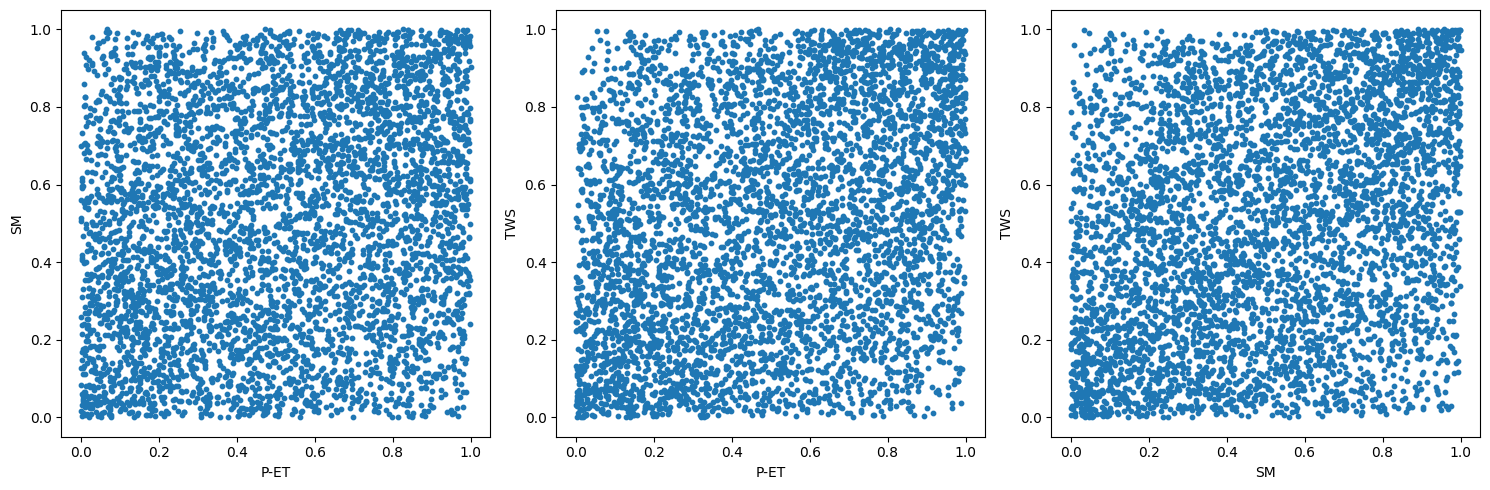

In [110]:
cop_samples = best_copula.random(5000)

# Plot scatter plots of sampled data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], s=10)
axes[0].set_xlabel('P-ET')
axes[0].set_ylabel('SM')
axes[1].scatter(cop_samples[:, 0], cop_samples[:, 2], s=10)
axes[1].set_xlabel('P-ET')
axes[1].set_ylabel('TWS')
axes[2].scatter(cop_samples[:, 1], cop_samples[:, 2], s=10)
axes[2].set_xlabel('SM')
axes[2].set_ylabel('TWS')
plt.tight_layout()
plt.show()

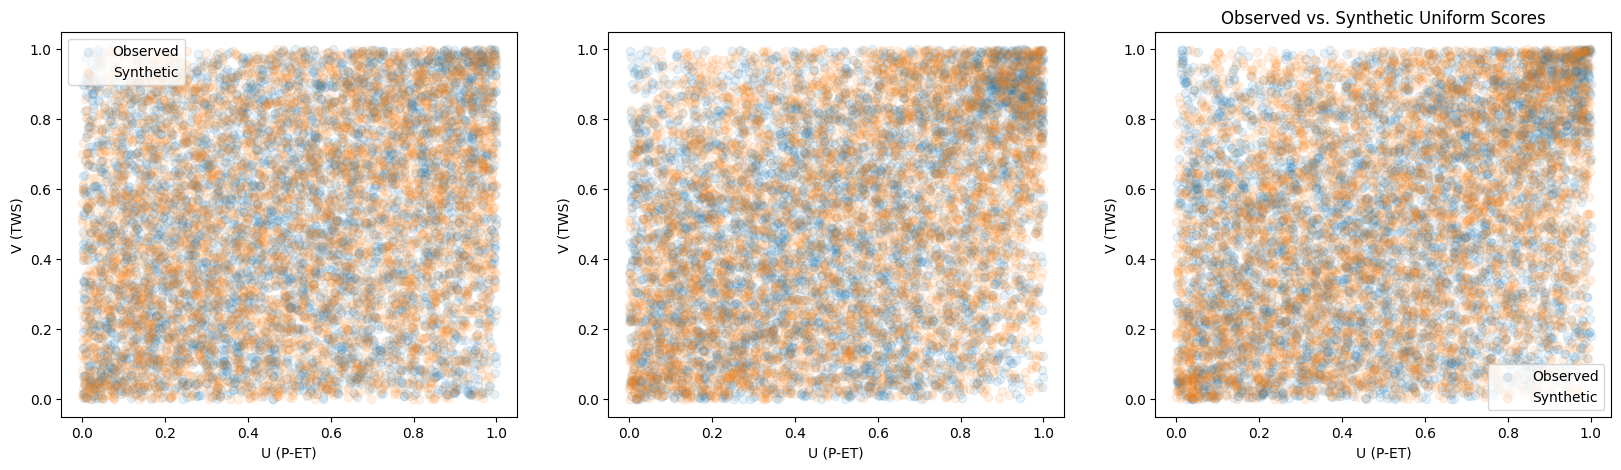

In [111]:
'Generate synthetic samples to compare with observed'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(uniform_sample[:,0], uniform_sample[:,1], alpha=0.1, label='Observed')
axes[0].scatter(cop_samples[:,0], cop_samples[:,1], alpha=0.1, label='Synthetic')
axes[0].set_xlabel('U (P-ET)')
axes[0].set_ylabel('V (TWS)')
axes[0].legend()

axes[1].scatter(uniform_sample[:,0], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[1].scatter(cop_samples[:,0], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[1].set_xlabel('U (P-ET)')
axes[1].set_ylabel('V (TWS)')
plt.legend()

axes[2].scatter(uniform_sample[:,1], uniform_sample[:,2], alpha=0.1, label='Observed')
axes[2].scatter(cop_samples[:,1], cop_samples[:,2], alpha=0.1, label='Synthetic')
axes[2].set_xlabel('U (P-ET)')
axes[2].set_ylabel('V (TWS)')

plt.legend()
plt.title('Observed vs. Synthetic Uniform Scores')
plt.show()

In [112]:
# # Load best copula
# copula_file = f'../../../datasets/results/copulas/fitted_copula_{subregion_id}_{timescale}.pkl'
# with open(copula_file, 'rb') as f:
#     best_copula = pickle.load(f)
# print(best_copula.name)

In [113]:
# Compute joint probabilities in batches
start_time = time.time()
stacked_uniform = uniform_ds.to_array(dim='variable').stack(sample=('time', 'y', 'x')).transpose('sample', 'variable')
n_samples = len(stacked_uniform['sample'])
joint_probs = []
valid_multi_indices = []

In [114]:
# Extract and flatten column names safely
columns = stacked_uniform['variable'].values.tolist()

# Convert to DataFrame
df = pd.DataFrame(stacked_uniform.compute().values, columns=columns)

# Proceed with valid row check
valid_rows = df.dropna().index
if valid_rows.empty:
    print("No valid rows in region.")
    exit()

df_valid = df.loc[valid_rows]

In [115]:
# Compute joint probabilities
start = time.time()
joint_probs = best_copula.cdf(df_valid.to_numpy())

# Get corresponding sample indices
valid_sample_ids = stacked_uniform.sample.values[valid_rows]
end = time.time()
print(f"Total runtime: {(start_time - end_time):.2f} seconds.")

Total runtime: 2.89 seconds.


In [116]:
# Reconstruct as xarray
multiindex = stacked_uniform['sample'].to_index()
valid_multiindex = multiindex[valid_rows]

joint_probs_da = xr.DataArray(
    joint_probs, 
    coords=[valid_multiindex], 
    dims='sample').unstack('sample').clip(1e-10, 1 - 1e-10)  # avoid infs


In [117]:
# Convert to drought index
ghdi_plains_360 = xr.apply_ufunc(
    norm.ppf, joint_probs_da).sortby(['y', 'x'])

ghdi_plains_360.name = "GHDIPlains_360"
ghdi_plains_360.attrs['long_name'] = "Greater Horn of Africa Drought Index"
ghdi_plains_360.attrs['units'] = "Standard Normal"

In [118]:
ghdi_plains_360['ghdi_360'] = ghdi_plains_360 - ghdi_plains_360.mean(dim='time')

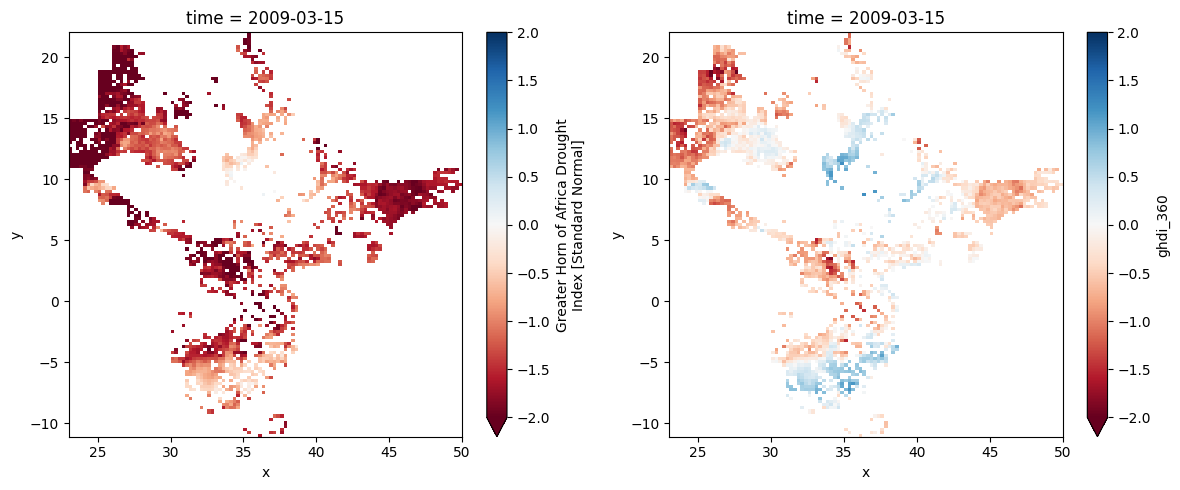

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Normalised index
ghdi_plains_360.isel(time=154).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
ghdi_plains_360.ghdi_360.isel(time=154).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

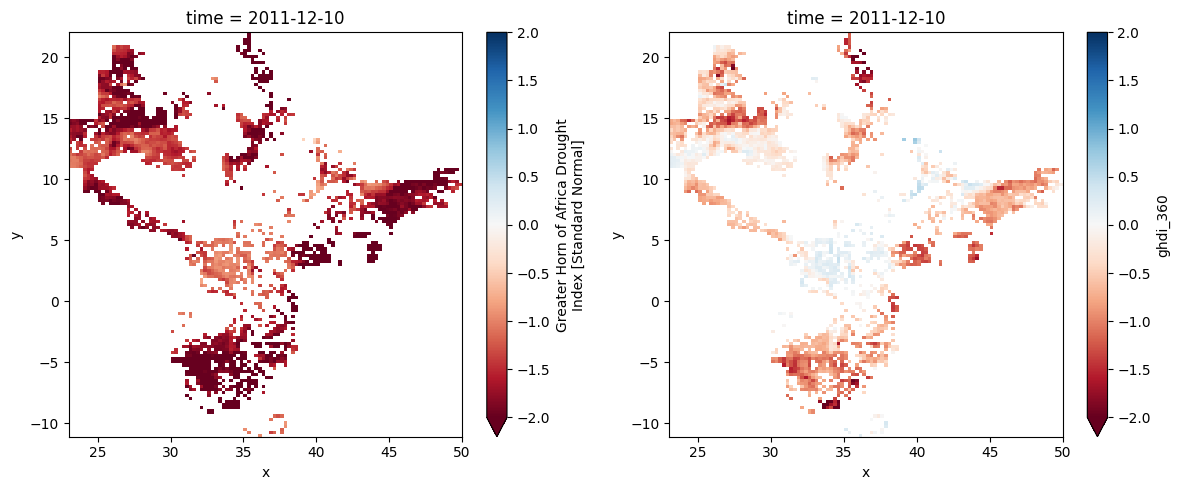

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ghdi_plains_360.isel(time=254).plot(
    ax=ax1, cmap='RdBu', robust=True, vmin=-2, vmax=2)
# Normalised index
ghdi_plains_360.ghdi_360.isel(time=254).plot(
    ax=ax2, cmap='RdBu', robust=True, vmin=-2, vmax=2)

plt.tight_layout()
plt.show()

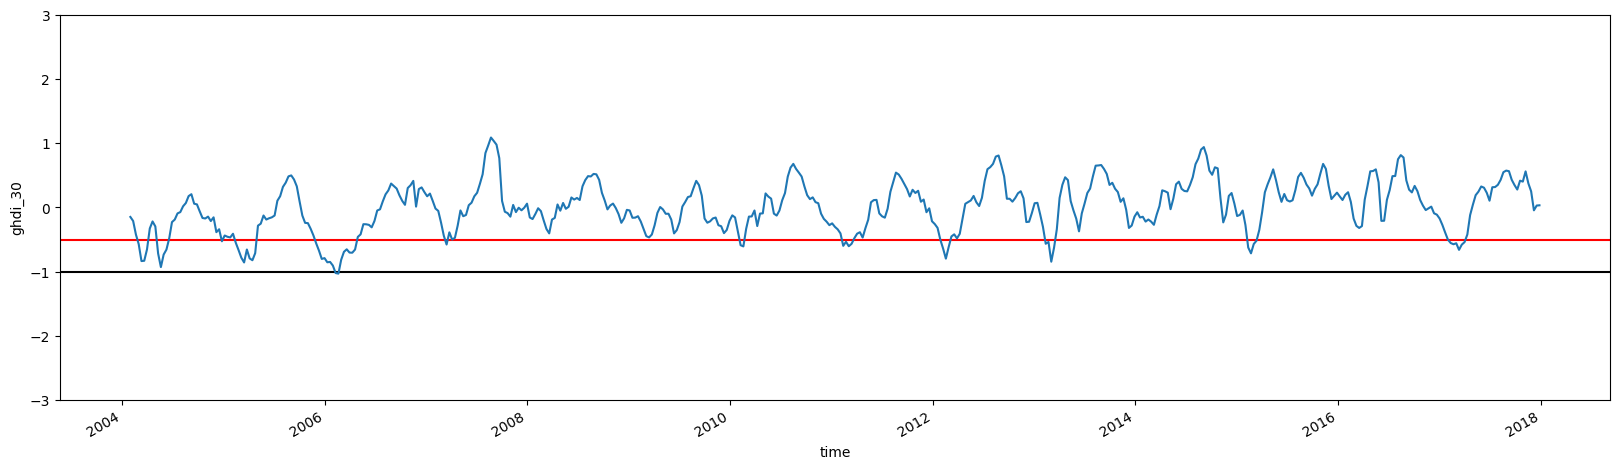

In [121]:
# Regional mean

# f = ghdi_plains.mean(dim=['x', 'y'])
ghdi_plains_360.ghdi_360.mean(dim=['x', 'y'])
plt.figure(figsize=(20, 5))
plt.ylim(-3, 3)
plt.axhline(-1, linestyle='-', color='k')
plt.axhline(-0.5, linestyle='-', color='red')
g.plot()

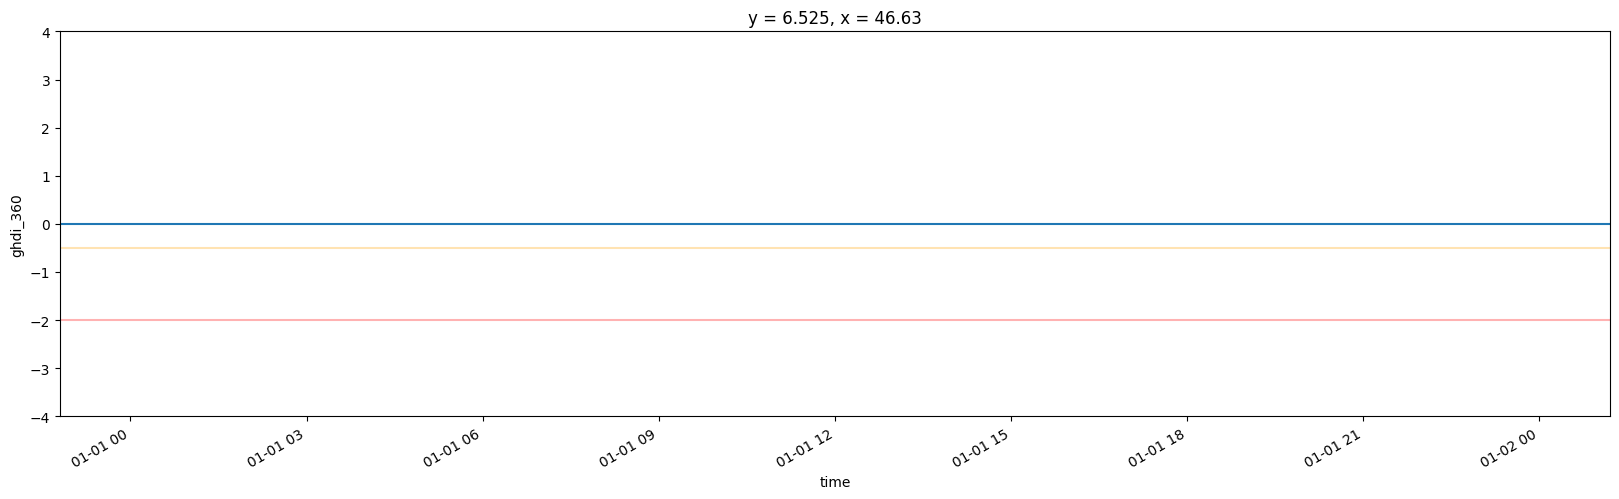

In [122]:
plt.figure(figsize=(20, 5))
ghdi_plains_360.ghdi_360.sel(y=6.61, x=46.72, method='nearest').plot()
plt.ylim(-4, 4)
plt.axhline(0)
plt.axhline(-0.5, color='orange', alpha=0.3)
plt.axhline(-2, color='red', alpha=0.3)

In [123]:
# plt.figure(figsize=(20, 5))
# ghdi_plains_360.ghdi_360.sel(y=-1, x=40, method='nearest').plot()
# plt.ylim(-4, 4)
# plt.axhline(0)
# plt.axhline(-0.5, color='orange', alpha=0.3)
# plt.axhline(-2, color='red', alpha=0.3)

In [124]:
# Save index to disk
ghdi_plains_360.to_netcdf(f'ghdi_{subregion_id}_{timescale}.nc')